# Úkol č. 2 - Využití neuronových sítí

  * **Deadline je 13. 5. 2024, 23:59:59**, pokud odevzdáte úkol do 20. 5. 2024, 23:59:59, budete penalizování -12 body, pozdější odevzdání je bez bodu.
  * V rámci tohoto úkolu musíte sestrojit vhodný model neuronové sítě pro vícetřídou klasifikaci.
  * Část bodů získáte za správné vypracování a část bodů získáte za výslednou přesnost Vašeho modelu na evaluačních datech.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budou strhávány body.

## Zdroj dat

 * Zdrojem dat jsou soubory `train.csv` a `evaluate.csv`.
 * Jedná se o obrázky 32x32 pixelů ve stupních šedi, které byly nějakým způsobem vyrobeny z [Fashion Mnist datasetu](https://www.kaggle.com/datasets/zalando-research/fashionmnist).
 * Soubor `train.csv` obsahuje trénovací data.
 * Cílová (vysvětlovaná) proměnná se jmenuje **label**.
 * Soubor `evaluate.csv` obsahuje testovací data bez hodnot skutečných labelů.

## Pokyny k vypracování (max 18 bodů)

**Body zadání**, za jejichž (poctivé) vypracování získáte **18 bodů**:
  * V notebooku načtěte data ze souboru `train.csv`. Vhodným způsobem si je rozdělte na podmnožiny, které Vám poslouží pro trénování, porovnávání modelů a následnou predikci výkonnosti finálního modelu.
  * Proveďte základní průzkum dat a svá pozorování diskutujte. Některé obrázky také zobrazte.
  * Sestrojte a natrénujte několik variant modelu dopředné neuronové sítě. Přitom v rámci výpočetních možností:
      * Okomentujte vhodnost daného modelu pro daný typ úlohy.
      * Experimentujte s různými hloubkami a velikostmi vrstev.
      * Experimentujte se standardizací/normalizací dat.
      * Experimentujte s různými optimalizačními metodami.
      * Experimentujte s různými regularizačními technikami.
      * Získané výsledky vždy řádně okomentujte.

  * Sestrojte model konvoluční neuronové sítě. Přitom v rámci výpočetních možností:
      * Okomentujte vhodnost daného modelu pro daný typ úlohy.
      * Experimentujte s různými hloubkami a velikostmi vrstev.
      * Experimentujte se standardizací/normalizací dat.
      * Experimentujte s různými optimalizačními metodami.
      * Experimentujte s různými regularizačními technikami.
      * Získané výsledky vždy řádně okomentujte.
    
  * Ze všech zkoušených možností vyberte finální model a odhadněte, jakou přesnost můžete očekávat na nových datech, která jste doposud neměli k dispozici.
  
  * Nakonec načtěte vyhodnocovací data ze souboru`evaluate.csv`. Pomocí finálního modelu napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte soubor `results.csv`, ve kterém získané predikce uložíte do sloupce **label** a identifikátory do sloupce **ID**. Tento soubor též odevzdejte (uložte do projektu vedle notebooku).
   
   * Ukázka prvních řádků souboru `results.csv`:
  
```
ID,label
0,0
1,1
...
```

## Vyhodnocovací část (max 7 bodů)
Za přesnost (accuraccy) na odevzdaných predikcích pro vyhodnocovací množnu získáte dalších max **7 bodů**.

Označíme-li $A$ přesnost, které jste dosáhli, zaokrouhlenou na 2 desetinná místa, akumulují se výsledné body podle následujících pravidel:
* pokud $A \geq 0.80$ obdržíte +1 bod
* pokud $A \geq 0.83$ obdržíte +1 bod
* pokud $A \geq 0.86$ obdržíte +1 bod
* pokud $A \geq 0.87$ obdržíte +1 bod
* pokud $A \geq 0.88$ obdržíte +1 bod
* pokud $A \geq 0.89$ obdržíte +1 bod
* pokud $A \geq 0.90$ obdržíte +1 bod

**Příklad:** Pokud bude Vaše přesnost 0.856, vyjde A = 0.86 a vy získáte 3 body.


## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML2/homeworks/index.html.
  * Vytvořte i csv soubor `results.csv` s predikcemi a uložte ho v rámci projektu vedle ipython notebooku.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset, Dataset, RandomSampler
from sklearn.model_selection import train_test_split
from torchvision import transforms
import random
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import itertools
import torch.optim as optim
import os
from sklearn.metrics import accuracy_score

In [2]:
torch.cuda.is_available()

True

In [3]:
# try to set device to GPU if CUDA is available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
torch.set_default_device(device)
torch.get_default_device()

device(type='cuda', index=0)

Hooray!!!

# Data reading

In [5]:
data = pd.read_csv("train.csv")

In [6]:
data.head(10)

,pix1,pix2,pix3,pix4,pix5,pix6,pix7,pix8,pix9,pix10,...,pix1016,pix1017,pix1018,pix1019,pix1020,pix1021,pix1022,pix1023,pix1024,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,3
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,7
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,5
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
7,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
9,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,6


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52500 entries, 0 to 52499
Columns: 1025 entries, pix1 to label
dtypes: int64(1025)
memory usage: 410.6 MB


In [8]:
display(data.shape)

(52500, 1025)

In [9]:
data.describe()

,pix1,pix2,pix3,pix4,pix5,pix6,pix7,pix8,pix9,pix10,...,pix1016,pix1017,pix1018,pix1019,pix1020,pix1021,pix1022,pix1023,pix1024,label
count,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000,...,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000,52500.000000
mean,0.877390,0.877390,0.877390,0.877390,0.877410,0.877429,0.877429,0.877543,0.878038,0.880648,...,0.929867,0.909143,0.893524,0.883505,0.878952,0.877467,0.877410,0.877390,0.877390,4.509752
std,1.493605,1.493605,1.493605,1.493605,1.493601,1.493596,1.493596,1.493682,1.494258,1.528912,...,2.835341,2.224631,1.794160,1.615415,1.505722,1.493854,1.493677,1.493605,1.493605,2.872106
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000
max,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,73.000000,...,187.000000,172.000000,134.000000,116.000000,41.000000,11.000000,11.000000,11.000000,11.000000,9.000000


In [10]:
data.isnull().sum(axis=0).sum()

0

In [11]:
display(data.nunique())

pix1       12
pix2       12
pix3       12
pix4       12
pix5       12
           ..
pix1021    12
pix1022    12
pix1023    12
pix1024    12
label      10
Length: 1025, dtype: int64

- As stated in the description, and it can be seen that we have data that represents 32*32 pixel grayscale images, where pixel represents a value in from 0 to 255. The target variable is "label", we have 52500 data samples of 10 classes, no null values. As in the previous task, the pixels on the edges have almost always a low, near-zero value.

I'll  show some pictures.

In [12]:
X = data.iloc[:, :1024].values  # pixel data
labels = data['label'].values   # labels

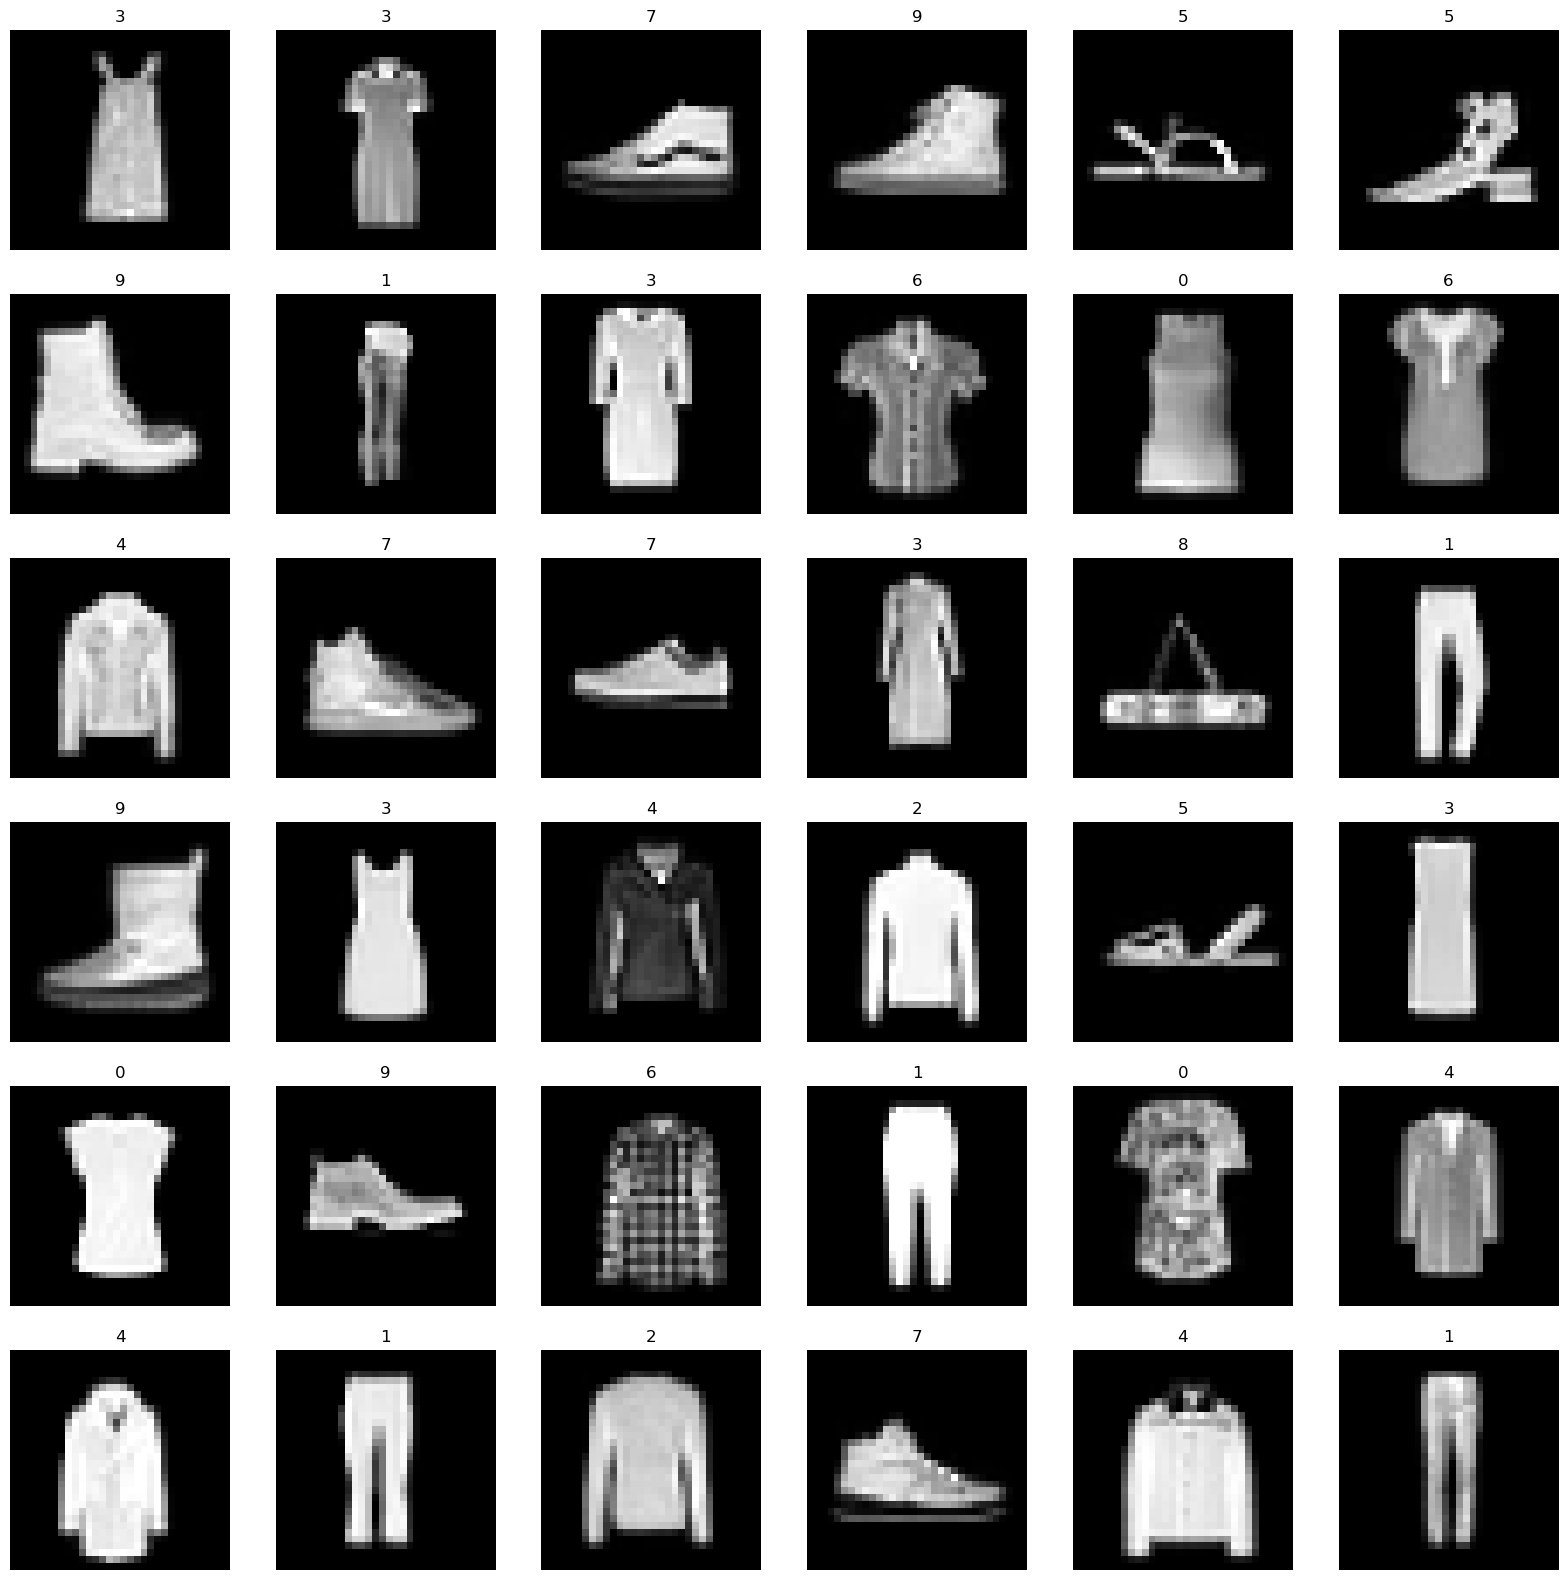

In [14]:
figure = plt.figure(figsize=(20, 20))
cols, rows = 6, 6
for i in range(cols * rows):
    img = X[i].reshape(32, 32)  # row into 32x32 image
    label = labels[i]
    figure.add_subplot(rows, cols, i+1)
    plt.title(f"{label}")
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

- I noticed that we have 3 classes representing different types of shoes, and the shoes can be rotated either right or left

# Prepare and split data

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = torch.Generator(device=device)
print("Generator device:", generator.device)

Generator device: cuda


In [24]:
class AddGaussianNoise(object):
    """Adds Gaussian noise to the tensor.

    This class is designed for data augmentation by adding Gaussian noise
    to tensors. The noise is generated with a given mean and standard deviation.
    It is used to create robustness of deep learning models to random noise in the data.

    Args:
        mean (float): The mean of the Gaussian noise distribution.
        std (float): The standard deviation of the Gaussian noise distribution.
    """
    def __init__(self, mean=0., std=1.):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn(tensor.size(), device=tensor.device) * self.std + self.mean
        return tensor + noise


    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [25]:
# Define transforms
transform_norm = transforms.Compose([
    transforms.ToTensor(), # convert to a tensor
    AddGaussianNoise(0., 0.05), # add Gaussian noise with 0 mean and standard deviation 0.05
    transforms.RandomHorizontalFlip(), # horizontal mirroring with 50% probability
])

transform_reg = transforms.Compose([
    transforms.ToTensor(), # convert to a tensor
    AddGaussianNoise(0., 12.75), # add Gaussian noise with 0 mean and standard deviation 12.75 (0.05 * 255)
    transforms.RandomHorizontalFlip(), # horizontal mirroring with 50% probability
])

basic_transform = transforms.Compose([
    transforms.ToTensor(),  # convert to a tensor
    transforms.Lambda(lambda x: x.float())
])

In [26]:
class CustomDataset(Dataset):
    """My customisable dataset in PyTorch.

    This class provides a mechanism to load data and associated labels,
    and to apply certain transformations to the data before using it.
    It inherits from PyTorch's Dataset class and overrides the __len__ and __getitem__ methods.

    Args:
        data (array-like): An array of data where each element is a single pattern.
        labels (array-like): An array of labels corresponding to the data.
        transform (callable, optional): The transformation function to be applied to each data item.
    """

    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]

        x = x.reshape((32, 32))

        if self.transform:
            x = self.transform(x)

        return x, y

- I decided to use a custom dataset and a set of transformations to train the model. This was done in order to improve the generalisation ability of the model and to adapt to the variability of data. Gaussian noise was chosen as a way to increase the robustness of the model to random distortion, and horizontal mirroring allows the model to efficiently handle objects whose orientation may vary. A custom dataset allows these augmentations to be integrated directly into the training process. I used the material in this article as a basis - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

In [27]:
# split the data into training, validation and test samples
X_train, X_temp, y_train, y_temp = train_test_split(X, labels, test_size=0.3, random_state=367) # 70% training, 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=367) # split temp into 50% validation and 50% test

- This results in 70% of the data for training, 15% for validation, and 15% for testing.

In [28]:
# Normalisation
X_train_norm = X_train / 255.0
X_val_norm = X_val / 255.0
X_test_norm = X_test / 255.0

In [29]:
train_dataset = CustomDataset(X_train, y_train, transform=transform_reg)
val_dataset = CustomDataset(X_val, y_val, transform=basic_transform) # no augmentation for validate and test data
test_dataset = CustomDataset(X_test, y_test, transform=basic_transform)

train_norm_dataset = CustomDataset(X_train, y_train, transform=transform_norm)
val_norm_dataset = CustomDataset(X_val, y_val, transform=basic_transform)
test_norm_dataset = CustomDataset(X_test, y_test, transform=basic_transform)

In [30]:
# create DataLoaders

sampler_reg = RandomSampler(train_dataset, generator=generator)
sampler_norm = RandomSampler(train_norm_dataset, generator=generator)
# reg data
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, sampler = sampler_reg)  # otherwise there was an error that the random number generator was on the CPU
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# normalised data
train_norm_loader = DataLoader(train_norm_dataset, batch_size=64, shuffle=False, sampler=sampler_norm)
val_norm_loader = DataLoader(val_norm_dataset, batch_size=64, shuffle=False)
test_norm_loader = DataLoader(test_norm_dataset, batch_size=64, shuffle=False)

# Feedforward Neural Network

- First, I'll try to implement a feed-forward neural network - a multi-layer preceptron model. This model is good with simple implementation in PyTorch and can achieve good results in computer vision tasks, but it does not always catch complex patterns in data, ignores spatial relationship between pixels (all data is translated into a one-dimensional array).

In [22]:
class DynamicMLP(nn.Module):
    """
    Multilayer perceptron (MLP) with dynamic layer configuration and optional Dropout regularisation.

    This class allows the creation of MLPs with an arbitrary number of layers and neurons, and with the ability to
    adding Dropout between layers to prevent overtraining.

    Args:
        layers (list): A list containing the number of neurons in each layer. The length of the list determines
                       the number of layers; the list values are the number of neurons in each corresponding layer.
        dropout_rate (float, optional): The probability of neurons in Dropout layers being switched off.
                                        The default is 0, which means no Dropout.
    """
    def __init__(self, layers, dropout_rate=0):
        super(DynamicMLP, self).__init__()
        self.layers = nn.ModuleList()
        self.dropout_rate = dropout_rate

        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))
            if i < len(layers) - 2:  # no activation function after last layer
                self.layers.append(nn.ReLU())
                if self.dropout_rate != 0:
                    self.layers.append(nn.Dropout(self.dropout_rate))

    def forward(self, x):
        x = x.flatten(start_dim = 1)
        for layer in self.layers:
            x = layer(x)
        return x

In [114]:
def reset_to_initial_state(m):
    """Reinitialize weights if the layer has 'reset_parameters' method."""
    if hasattr(m, 'reset_parameters'):
        print(f"Resetting parameters of layer {type(m)}")
        m.reset_parameters()
    else:
        print(f"No reset_parameters method available for layer {type(m)}")


In [24]:
def l1_regularization(model, loss, lambda_term):
    """adds L1 regularization"""
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    loss = loss + lambda_term * l1_norm
    return loss

In [81]:
# code in this cell was taken from cviceni 10 notebook
def train_one_epoch(model, loss_fn, optimizer, training_loader, lreg = False):
    running_cum_loss = 0.
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for data in iter(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        if lreg:
            loss = l1_regularization(model, loss, 0.0001)

        # Backpropagation
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        last_mean_loss = loss.item()
        running_cum_loss += last_mean_loss * inputs.shape[0]

    # Return of the average over the whole training set
    return running_cum_loss / len(training_loader.dataset)

In [88]:
# Code in this cell was taken from cvičeni 10 notebook
# Maximum number of training epochs
MAX_EPOCHS = 30
# Number of epochs when we are willing to accept that there will be no improvement. Otherwise, we stop learning.
K_EPOCHS = 7

def train_n_epochs(model, loss_fn, optimizer, training_loader, validate_loader, save_path, regularization=False):
    epochs_list = []
    train_loss = []
    validation_loss = []
    best_vloss = 1000000.
    epochs_from_best = 0

    for epoch in range(MAX_EPOCHS):
        # print('EPOCH {}:'.format(epoch + 1))

        model.train()
        # One training step
        avg_loss = train_one_epoch(model, loss_fn, optimizer, training_loader, regularization)

        model.eval()
        # Validation performance
        running_cum_vloss = 0.0
        vcorrect = 0
        for i, vdata in enumerate(validate_loader):
            vinputs, vlabels = vdata
            vinputs, vlabels = vinputs.to(device), vlabels.to(device)
            with torch.no_grad():
                voutputs = model(vinputs)
                vloss = loss_fn(voutputs, vlabels)
            running_cum_vloss += vloss * vinputs.shape[0]
            # count the correctly classified samples
            vcorrect += (voutputs.argmax(1) == vlabels).float().sum()
        # Get average loss and accuraccy on valid data
        avg_vloss = running_cum_vloss / len(validate_loader.dataset)
        vacc = vcorrect / len(validate_loader.dataset)

        # collect values
        epochs_list.append(epoch)
        validation_loss.append(avg_vloss)
        train_loss.append(avg_loss)

        # print(f"TRAIN loss: {avg_loss:.3f}, VALIDATION loss: {avg_vloss:.3f}, accuraccy: {vacc:.3f}")

        # Track the best performance, and save the model's state
        if avg_vloss < best_vloss:
            # print("Saving best model")
            best_vloss = avg_vloss
            if not os.path.exists(os.path.dirname(save_path)):
                os.makedirs(os.path.dirname(save_path))
            torch.save(model.state_dict(), save_path)
            epochs_from_best = 0
        else:
            # print("No improvement in this epoch.")
            epochs_from_best += 1

        # EARLY STOPPING
        if epochs_from_best > K_EPOCHS:
            # print("Early stopping now")
            break

    return best_vloss


- I use an early stop to detect overtraining and stop calculations.

## Tuning MLP model

In [90]:
# possible configurations
layer_configurations = [
    [1024, 512, 10],
    [1024, 256, 128, 10],
    [1024, 512, 256, 10],
    [1024, 512, 256, 128, 10],
    [1024, 512, 256, 128, 64, 10],
]

# optimizers and their parameters
optimizers = {
    'Adam': {"lr": [0.001, 0.0001], "weight_decay": [0.001, 0.01]},
    'SGD': {"lr": [0.01, 0.005], "momentum": [0.9], "weight_decay": [0.001, 0.01]}
}

# Dropout и regularization
dropout_rates = [0, 0.25, 0.5]
regularizations = ['l1', 'l2', None]

# all combs
param_grid = list(itertools.product(
    layer_configurations,
    optimizers.items(),
    dropout_rates,
    regularizations
))

loss_fn = torch.nn.CrossEntropyLoss()

- By experimenting with these settings, I aim to identify the best configuration that provides the highest validation accuracy. This methodical yet randomized approach allows for a broad exploration of the parameter space, ensuring that the final model is both robust and effective.

In [91]:
def train_model_with_params(layers, optimizer_info, dropout, regularization, train_loader, val_loader, model_save_dir, model_id):
    model = DynamicMLP(layers, dropout)
    model.to(device)
    optimizer_name, opts = optimizer_info

    optimizer_params = {k: random.choice(v) for k, v in opts.items() if k != 'weight_decay'}
    if regularization == 'l2':
        optimizer_params['weight_decay'] = random.choice(opts['weight_decay'])

    optimizer = getattr(optim, optimizer_name)(model.parameters(), **optimizer_params)
    model_save_path = os.path.join(model_save_dir, f"model_{model_id}.pt")


    return train_n_epochs(model, loss_fn, optimizer, train_loader, val_loader, model_save_path, regularization=="l1")


- Before I ran the big training session, I ran one model and saw that everything was fine. I'm going to train 60 models, 30 on normalised data and 30 not, so I've removed all progress prints for now

In [92]:
# choose random configs
random_samples = np.random.choice(len(param_grid), 30, replace=False)

In [98]:
validation_losses_reg = {}
for i, config in enumerate(random_samples):
    layers, optimizer_info, dropout, regularization = param_grid[config]
    print(f"Training model {i}...")
    val_loss = train_model_with_params(
        layers, optimizer_info, dropout, regularization, train_loader, val_loader, "./model_saves", f"config_{i}"
    )
    validation_losses_reg[val_loss] = [layers, optimizer_info, dropout, regularization]

Training model 0...
Training model 1...
Training model 2...
Training model 3...
Training model 4...
Training model 5...
Training model 6...
Training model 7...
Training model 8...
Training model 9...
Training model 10...
Training model 11...
Training model 12...
Training model 13...
Training model 14...
Training model 15...
Training model 16...
Training model 17...
Training model 18...
Training model 19...
Training model 20...
Training model 21...
Training model 22...
Training model 23...
Training model 24...
Training model 25...
Training model 26...
Training model 27...
Training model 28...
Training model 29...


In [99]:
min_key = min(validation_losses_reg.keys())
min_value = validation_losses_reg[min_key]
print(min_key, min_value)

tensor(0.4061, device='cuda:0') [[1024, 512, 256, 10], ('Adam', {'lr': [0.001, 0.0001], 'weight_decay': [0.001, 0.01]}), 0, None]


In [100]:
keys_list = list(validation_losses_reg.keys())
index = keys_list.index(min_key)
print(index)
print(len(validation_losses_reg.keys()))

5
30


- This shows me the architecture of the best model for not normalised data and I know its index. So the weights will be in ./model_saves/model_config_5.pt

In [101]:
validation_losses_norm = {}
for i, config in enumerate(random_samples):
    layers, optimizer_info, dropout, regularization = param_grid[config]
    print(f"Training model {i}...")
    val_loss = train_model_with_params(
        layers, optimizer_info, dropout, regularization, train_norm_loader, val_norm_loader, "./model_saves", f"config_{30+i}"
    )
    validation_losses_norm[val_loss] = [layers, optimizer_info, dropout, regularization]

Training model 0...
Training model 1...
Training model 2...
Training model 3...
Training model 4...
Training model 5...
Training model 6...
Training model 7...
Training model 8...
Training model 9...
Training model 10...
Training model 11...
Training model 12...
Training model 13...
Training model 14...
Training model 15...
Training model 16...
Training model 17...
Training model 18...
Training model 19...
Training model 20...
Training model 21...
Training model 22...
Training model 23...
Training model 24...
Training model 25...
Training model 26...
Training model 27...
Training model 28...
Training model 29...


In [102]:
min_key1 = min(validation_losses_norm.keys())
min_value1 = validation_losses_norm[min_key1]
print(min_key1, min_value1)

tensor(0.4116, device='cuda:0') [[1024, 512, 256, 128, 64, 10], ('SGD', {'lr': [0.01, 0.005], 'momentum': [0.9], 'weight_decay': [0.001, 0.01]}), 0, 'l2']


In [103]:
keys_list = list(validation_losses_norm.keys())
index = keys_list.index(min_key1)
print(index)
print(len(validation_losses_norm.keys()))

20
30


- The weights will be in ./model_saves/model_config_50.pt

# Best MLP model

In [35]:
def evaluate_model(model, data_loader, device):
    """
    Evaluate a model on a dataset provided by a DataLoader.
    """
    val_predictions = np.zeros(len(data_loader.dataset))
    val_y = np.zeros(len(data_loader.dataset))
    index = 0

    for vdata in tqdm(data_loader, desc="Evaluating model", leave=False):
        vinputs, vlabels = vdata
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)

        with torch.no_grad():
            voutputs = model(vinputs)


        val_predictions[index:(index + vinputs.shape[0])] = voutputs.argmax(1).cpu().numpy()
        val_y[index:(index + vinputs.shape[0])] = vlabels.cpu().numpy()
        index += vinputs.shape[0]

    print(f"Validate accuracy: {accuracy_score(val_y, val_predictions):.6f}")
    return val_y, val_predictions

In [188]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and builds an error matrix.
    Normalisation can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True values')
    plt.xlabel('Predicted values')

In [196]:
# no normalisation
model_reg = DynamicMLP([1024, 512, 256, 10])
model_reg.load_state_dict(torch.load('model_saves/model_config_5.pt'))
model_reg.eval()

DynamicMLP(
  (layers): ModuleList(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [197]:
class_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
val_y, val_pred = evaluate_model(model_reg, val_loader, device)

Validate accuracy: 0.857143


In [186]:
# with normalisation
model_norm = DynamicMLP([1024, 512, 256, 128, 64, 10])
model_norm.load_state_dict(torch.load('model_saves/model_config_50.pt'))
model_norm.eval()

DynamicMLP(
  (layers): ModuleList(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [189]:
val_y_norm, val_pred_norm = evaluate_model(model_norm, val_norm_loader, device)
cnf = confusion_matrix(val_y_norm, val_pred_norm)

Validate accuracy: 0.859175


- The normalised data showed a slightly better result, which is around 0.86. I think this is pretty good for a multilayer perceptron. Let me draw a confusion matrix

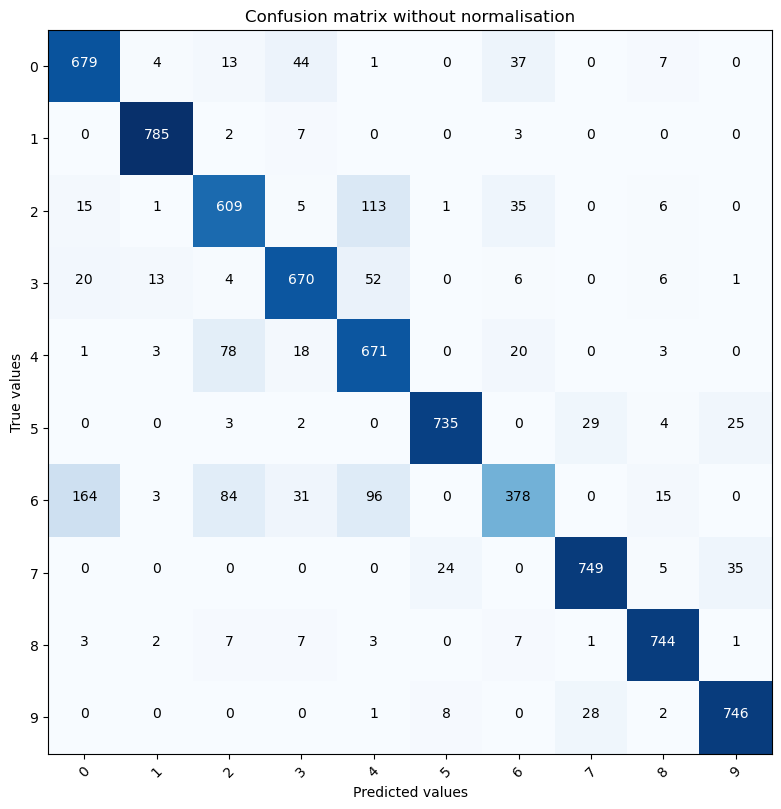

In [137]:
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf, classes=class_names, title='Confusion matrix without normalisation' )
plt.show()

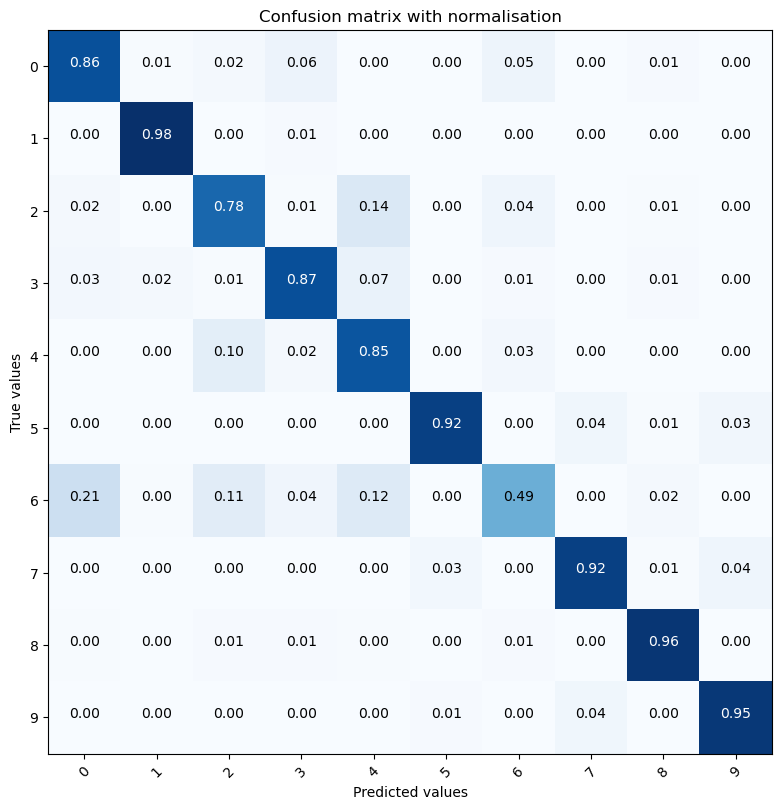

In [119]:
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf, classes=class_names, normalize=True, title='Confusion matrix with normalisation' )
plt.show()

- What stands out immediately is that class 6 is often confused with class 0 (labelled as ‘0’ on the vertical axis), with a probability of about 0.21. The model quite often erroneously predicts that it is class 0. Less frequently, 6 is confused with 4 and 2. If you look at the pictures and data at https://www.kaggle.com/datasets/zalando-research/fashionmnist, these are all items of outerwear that can be very similar to the human eye as well. Let's move on to the CNN.

# Convolutional Neural Network

- CNNs are specifically designed for image processing. They can automatically and efficiently extract important visual features due to their convolutional layer architecture, making them ideal for image recognition tasks. CNNs are capable of learning feature hierarchies, which allows them to recognise objects in images at different levels of complexity (from simple textures to complex objects). However, one has to keep an eye on over-learning and also a simple student like me faces the problem of computational power requirement and training time. CNN is also very difficult to interpret.

In [83]:
def train_one_epochCNN(model, loss_fn, optimizer, training_loader, lreg=False):
    running_cum_loss = 0.

    # tqdm is used for nice progress visualisation
    for data in tqdm(training_loader, total=len(training_loader)):
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        inputs = inputs.float()
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        if lreg:
            loss = l1_regularization(model, loss, 0.0001)

        # Backpropagation
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        last_mean_loss = loss.item()
        running_cum_loss += last_mean_loss * inputs.shape[0]

    # Return of the average over the whole training set
    return running_cum_loss / len(training_loader.dataset)

In [84]:
# Maximum number of training epochs
MAX_EPOCHS = 100
# Number of epochs when we are willing to accept that there will be no improvement. Otherwise, we stop learning.
K_EPOCHS = 15

def train_n_epochsCNN(model, loss_fn, optimizer, training_loader, validation_loader, save_path, lreg=False):
    epochs_list = []
    train_loss = []
    validation_loss = []
    best_vloss = 1000000.
    epochs_from_best = 0

    for epoch in range(MAX_EPOCHS):
        print('EPOCH {}:'.format(epoch + 1))

        # Indicate training phase
        model.train(True)

        # One training step
        avg_loss = train_one_epochCNN(model, loss_fn, optimizer, training_loader, lreg)

        # Indicate evaluation phase
        model.eval()

        # Validation performance
        running_cum_vloss = 0.0
        vcorrect = 0
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            vinputs, vlabels = vinputs.to(device), vlabels.to(device)
            with torch.no_grad():
                voutputs = model(vinputs)
                vloss = loss_fn(voutputs, vlabels)
            running_cum_vloss += vloss * vinputs.shape[0]
            # count the correctly classified samoples
            vcorrect += (voutputs.argmax(1) == vlabels).float().sum()
        # Get average loss and accuraccy
        avg_vloss = running_cum_vloss / len(validation_loader.dataset)
        vacc = vcorrect / len(validation_loader.dataset)

        # collect values
        epochs_list.append(epoch)
        validation_loss.append(avg_vloss)
        train_loss.append(avg_loss)

        # Report progress
        print(f"TRAIN loss: {avg_loss:.3f}, VALIDATION loss: {avg_vloss:.3f}, accuraccy: {vacc:.3f}")

        # Track the best performance, and save the model's state
        if avg_vloss < best_vloss:
            print("Saving best model")
            best_vloss = avg_vloss
            if not os.path.exists(os.path.dirname(save_path)):
                os.makedirs(os.path.dirname(save_path))
            torch.save(model.state_dict(), save_path)
            epochs_from_best = 0
        else:
            print("No improvement in this epoch.")
            epochs_from_best += 1

        # EARLY STOPPING
        if epochs_from_best > K_EPOCHS:
            print("Early stopping now")
            break
    return train_loss, validation_loss

- It's the same as MLP, but with a nice write-up of the training process. I've increased the maximum number of epochs.

In [25]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNetwork, self).__init__()
        # Define the first convolutional layer with 32 filters and a 3x3 kernel
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding='same')
        # Define a second convolution layer with 64 filters and a kernel size of 3x3
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        # Pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Full-link layer
        self.fc1 = nn.Linear(4096, 128) # Size after pooling and convolution
        # Output layer
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Applying the first convolution layer and pooling
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # Applying the second convolution layer and pooling
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # Flattening the data for the fully-connected layer
        x = x.flatten(start_dim=1)
        # First full-link layer
        x = F.relu(self.fc1(x))
        # Output layer
        x = self.fc2(x)
        return x

- This convolutional network is a starting point for me, I made a simple structure to see how things work and what direction to go in next

In [131]:
conv_model = ConvolutionalNetwork()
conv_model.to(device)

ConvolutionalNetwork(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [132]:
loss_fn = torch.nn.CrossEntropyLoss()

In [133]:
optimizer = torch.optim.Adam(conv_model.parameters())

In [134]:
tr_loss1_1, val_loss1_1 = train_n_epochsCNN(conv_model, loss_fn, optimizer, train_loader, val_loader, "savesCNN/model1_1.pt")

EPOCH 1:


100%|██████████| 575/575 [00:07<00:00, 76.16it/s]


TRAIN loss: 0.917, VALIDATION loss: 0.518, accuraccy: 0.812
Saving best model
EPOCH 2:


100%|██████████| 575/575 [00:07<00:00, 73.24it/s]


TRAIN loss: 0.467, VALIDATION loss: 0.479, accuraccy: 0.818
Saving best model
EPOCH 3:


100%|██████████| 575/575 [00:07<00:00, 75.16it/s]


TRAIN loss: 0.427, VALIDATION loss: 0.450, accuraccy: 0.830
Saving best model
EPOCH 4:


100%|██████████| 575/575 [00:07<00:00, 73.50it/s]


TRAIN loss: 0.396, VALIDATION loss: 0.418, accuraccy: 0.843
Saving best model
EPOCH 5:


100%|██████████| 575/575 [00:07<00:00, 76.73it/s]


TRAIN loss: 0.380, VALIDATION loss: 0.408, accuraccy: 0.843
Saving best model
EPOCH 6:


100%|██████████| 575/575 [00:07<00:00, 75.62it/s]


TRAIN loss: 0.363, VALIDATION loss: 0.508, accuraccy: 0.801
No improvement in this epoch.
EPOCH 7:


100%|██████████| 575/575 [00:07<00:00, 75.04it/s]


TRAIN loss: 0.355, VALIDATION loss: 0.489, accuraccy: 0.804
No improvement in this epoch.
EPOCH 8:


100%|██████████| 575/575 [00:07<00:00, 74.60it/s]


TRAIN loss: 0.346, VALIDATION loss: 0.417, accuraccy: 0.842
No improvement in this epoch.
EPOCH 9:


100%|██████████| 575/575 [00:07<00:00, 76.29it/s]


TRAIN loss: 0.338, VALIDATION loss: 0.425, accuraccy: 0.835
No improvement in this epoch.
EPOCH 10:


100%|██████████| 575/575 [00:07<00:00, 74.19it/s]


TRAIN loss: 0.328, VALIDATION loss: 0.463, accuraccy: 0.822
No improvement in this epoch.
EPOCH 11:


100%|██████████| 575/575 [00:07<00:00, 75.03it/s]


TRAIN loss: 0.319, VALIDATION loss: 0.438, accuraccy: 0.831
No improvement in this epoch.
EPOCH 12:


100%|██████████| 575/575 [00:07<00:00, 76.52it/s]


TRAIN loss: 0.312, VALIDATION loss: 0.416, accuraccy: 0.846
No improvement in this epoch.
EPOCH 13:


100%|██████████| 575/575 [00:07<00:00, 77.26it/s]


TRAIN loss: 0.309, VALIDATION loss: 0.447, accuraccy: 0.830
No improvement in this epoch.
EPOCH 14:


100%|██████████| 575/575 [00:08<00:00, 68.70it/s]


TRAIN loss: 0.306, VALIDATION loss: 0.431, accuraccy: 0.837
No improvement in this epoch.
EPOCH 15:


100%|██████████| 575/575 [00:07<00:00, 73.64it/s]


TRAIN loss: 0.300, VALIDATION loss: 0.415, accuraccy: 0.845
No improvement in this epoch.
EPOCH 16:


100%|██████████| 575/575 [00:07<00:00, 76.04it/s]


TRAIN loss: 0.292, VALIDATION loss: 0.408, accuraccy: 0.846
Saving best model
EPOCH 17:


100%|██████████| 575/575 [00:07<00:00, 73.58it/s]


TRAIN loss: 0.287, VALIDATION loss: 0.455, accuraccy: 0.830
No improvement in this epoch.
EPOCH 18:


100%|██████████| 575/575 [00:07<00:00, 75.42it/s]


TRAIN loss: 0.285, VALIDATION loss: 0.419, accuraccy: 0.846
No improvement in this epoch.
EPOCH 19:


100%|██████████| 575/575 [00:07<00:00, 75.94it/s]


TRAIN loss: 0.283, VALIDATION loss: 0.435, accuraccy: 0.829
No improvement in this epoch.
EPOCH 20:


100%|██████████| 575/575 [00:07<00:00, 76.08it/s]


TRAIN loss: 0.278, VALIDATION loss: 0.427, accuraccy: 0.842
No improvement in this epoch.
EPOCH 21:


100%|██████████| 575/575 [00:08<00:00, 66.75it/s]


TRAIN loss: 0.275, VALIDATION loss: 0.453, accuraccy: 0.839
No improvement in this epoch.
EPOCH 22:


100%|██████████| 575/575 [00:09<00:00, 62.63it/s]


TRAIN loss: 0.269, VALIDATION loss: 0.410, accuraccy: 0.855
No improvement in this epoch.
EPOCH 23:


100%|██████████| 575/575 [00:09<00:00, 60.40it/s]


TRAIN loss: 0.269, VALIDATION loss: 0.428, accuraccy: 0.846
No improvement in this epoch.
EPOCH 24:


100%|██████████| 575/575 [00:09<00:00, 58.09it/s]


TRAIN loss: 0.262, VALIDATION loss: 0.457, accuraccy: 0.841
No improvement in this epoch.
EPOCH 25:


100%|██████████| 575/575 [00:09<00:00, 60.87it/s]


TRAIN loss: 0.260, VALIDATION loss: 0.453, accuraccy: 0.830
No improvement in this epoch.
EPOCH 26:


100%|██████████| 575/575 [00:09<00:00, 60.35it/s]


TRAIN loss: 0.258, VALIDATION loss: 0.470, accuraccy: 0.833
No improvement in this epoch.
EPOCH 27:


100%|██████████| 575/575 [00:09<00:00, 63.85it/s]


TRAIN loss: 0.253, VALIDATION loss: 0.470, accuraccy: 0.833
No improvement in this epoch.
EPOCH 28:


100%|██████████| 575/575 [00:08<00:00, 70.21it/s]


TRAIN loss: 0.252, VALIDATION loss: 0.444, accuraccy: 0.847
No improvement in this epoch.
EPOCH 29:


100%|██████████| 575/575 [00:07<00:00, 79.53it/s]


TRAIN loss: 0.247, VALIDATION loss: 0.429, accuraccy: 0.856
No improvement in this epoch.
EPOCH 30:


100%|██████████| 575/575 [00:07<00:00, 79.11it/s]


TRAIN loss: 0.250, VALIDATION loss: 0.440, accuraccy: 0.851
No improvement in this epoch.
EPOCH 31:


100%|██████████| 575/575 [00:06<00:00, 82.60it/s]


TRAIN loss: 0.243, VALIDATION loss: 0.440, accuraccy: 0.852
No improvement in this epoch.
EPOCH 32:


100%|██████████| 575/575 [00:07<00:00, 81.97it/s]


TRAIN loss: 0.238, VALIDATION loss: 0.476, accuraccy: 0.840
No improvement in this epoch.
Early stopping now


In [135]:
conv_model = ConvolutionalNetwork()
conv_model.to(device)

ConvolutionalNetwork(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [136]:
optimizer = torch.optim.Adam(conv_model.parameters())

In [137]:
tr_loss1_2, val_loss1_2 = train_n_epochsCNN(conv_model, loss_fn, optimizer, train_norm_loader, val_norm_loader, "savesCNN/model1_2.pt")

EPOCH 1:


100%|██████████| 575/575 [00:07<00:00, 78.23it/s]


TRAIN loss: 0.803, VALIDATION loss: 0.440, accuraccy: 0.838
Saving best model
EPOCH 2:


100%|██████████| 575/575 [00:07<00:00, 76.19it/s]


TRAIN loss: 0.399, VALIDATION loss: 0.383, accuraccy: 0.861
Saving best model
EPOCH 3:


100%|██████████| 575/575 [00:07<00:00, 80.60it/s]


TRAIN loss: 0.351, VALIDATION loss: 0.381, accuraccy: 0.866
Saving best model
EPOCH 4:


100%|██████████| 575/575 [00:07<00:00, 77.80it/s]


TRAIN loss: 0.322, VALIDATION loss: 0.352, accuraccy: 0.872
Saving best model
EPOCH 5:


100%|██████████| 575/575 [00:08<00:00, 71.34it/s]


TRAIN loss: 0.301, VALIDATION loss: 0.329, accuraccy: 0.881
Saving best model
EPOCH 6:


100%|██████████| 575/575 [00:08<00:00, 67.13it/s]


TRAIN loss: 0.285, VALIDATION loss: 0.331, accuraccy: 0.883
No improvement in this epoch.
EPOCH 7:


100%|██████████| 575/575 [00:08<00:00, 70.59it/s]


TRAIN loss: 0.266, VALIDATION loss: 0.344, accuraccy: 0.887
No improvement in this epoch.
EPOCH 8:


100%|██████████| 575/575 [00:08<00:00, 69.66it/s]


TRAIN loss: 0.252, VALIDATION loss: 0.329, accuraccy: 0.885
No improvement in this epoch.
EPOCH 9:


100%|██████████| 575/575 [00:08<00:00, 67.55it/s]


TRAIN loss: 0.234, VALIDATION loss: 0.418, accuraccy: 0.861
No improvement in this epoch.
EPOCH 10:


100%|██████████| 575/575 [00:09<00:00, 63.18it/s]


TRAIN loss: 0.230, VALIDATION loss: 0.354, accuraccy: 0.879
No improvement in this epoch.
EPOCH 11:


100%|██████████| 575/575 [00:08<00:00, 67.99it/s]


TRAIN loss: 0.215, VALIDATION loss: 0.366, accuraccy: 0.878
No improvement in this epoch.
EPOCH 12:


100%|██████████| 575/575 [00:09<00:00, 60.55it/s]


TRAIN loss: 0.206, VALIDATION loss: 0.357, accuraccy: 0.884
No improvement in this epoch.
EPOCH 13:


100%|██████████| 575/575 [00:08<00:00, 65.20it/s]


TRAIN loss: 0.196, VALIDATION loss: 0.351, accuraccy: 0.888
No improvement in this epoch.
EPOCH 14:


100%|██████████| 575/575 [00:08<00:00, 67.72it/s]


TRAIN loss: 0.187, VALIDATION loss: 0.369, accuraccy: 0.893
No improvement in this epoch.
EPOCH 15:


100%|██████████| 575/575 [00:08<00:00, 70.76it/s]


TRAIN loss: 0.179, VALIDATION loss: 0.383, accuraccy: 0.887
No improvement in this epoch.
EPOCH 16:


100%|██████████| 575/575 [00:08<00:00, 70.95it/s]


TRAIN loss: 0.172, VALIDATION loss: 0.409, accuraccy: 0.884
No improvement in this epoch.
EPOCH 17:


100%|██████████| 575/575 [00:08<00:00, 70.67it/s]


TRAIN loss: 0.160, VALIDATION loss: 0.425, accuraccy: 0.887
No improvement in this epoch.
EPOCH 18:


100%|██████████| 575/575 [00:08<00:00, 64.16it/s]


TRAIN loss: 0.152, VALIDATION loss: 0.430, accuraccy: 0.882
No improvement in this epoch.
EPOCH 19:


100%|██████████| 575/575 [00:09<00:00, 62.39it/s]


TRAIN loss: 0.151, VALIDATION loss: 0.430, accuraccy: 0.887
No improvement in this epoch.
EPOCH 20:


100%|██████████| 575/575 [00:08<00:00, 66.52it/s]


TRAIN loss: 0.145, VALIDATION loss: 0.413, accuraccy: 0.890
No improvement in this epoch.
EPOCH 21:


100%|██████████| 575/575 [00:08<00:00, 66.26it/s]


TRAIN loss: 0.136, VALIDATION loss: 0.436, accuraccy: 0.886
No improvement in this epoch.
Early stopping now


- The normalised data show a significantly better result, so I will only continue with them, both times model overtrained quickly, I will try adding dropout.

In [119]:
class ConvolutionalNetwork2(nn.Module):
    def __init__(self):
        super(ConvolutionalNetwork2, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding='same')

        # Pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dropout layers
        self.dropout_input = nn.Dropout(p=0.1)  # Dropout for input layer
        self.dropout_internal = nn.Dropout(p=0.25)  # Dropout for internal layers

        # Fully connected layers
        self.fc1 = nn.Linear(4096, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Apply dropout to the input
        x = self.dropout_input(x)

        # First convolutional layer and pooling
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        # Second convolutional layer and pooling
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        # Flattening the data for the fully-connected layer
        x = x.flatten(start_dim=1)

        # First fully-connected layer
        x = F.relu(self.fc1(x))
        x = self.dropout_internal(x)  # Apply dropout before the final layer

        # Output layer
        x = self.fc2(x)

        return x

In [138]:
conv2_model = ConvolutionalNetwork2()
conv2_model.to(device)

ConvolutionalNetwork2(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout_input): Dropout(p=0.1, inplace=False)
  (dropout_internal): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [139]:
optimizer2 = torch.optim.Adam(conv2_model.parameters())

In [140]:
tr_loss2, val_loss2 = train_n_epochsCNN(conv2_model, loss_fn, optimizer2, train_norm_loader, val_norm_loader, "savesCNN/model2", True)
# this time I will also try l1 regularization

EPOCH 1:


100%|██████████| 575/575 [00:09<00:00, 60.45it/s]


TRAIN loss: 1.171, VALIDATION loss: 0.475, accuraccy: 0.822
Saving best model
EPOCH 2:


100%|██████████| 575/575 [00:09<00:00, 59.42it/s]


TRAIN loss: 0.750, VALIDATION loss: 0.435, accuraccy: 0.837
Saving best model
EPOCH 3:


100%|██████████| 575/575 [00:09<00:00, 61.52it/s]


TRAIN loss: 0.671, VALIDATION loss: 0.426, accuraccy: 0.842
Saving best model
EPOCH 4:


100%|██████████| 575/575 [00:09<00:00, 59.05it/s]


TRAIN loss: 0.629, VALIDATION loss: 0.398, accuraccy: 0.854
Saving best model
EPOCH 5:


100%|██████████| 575/575 [00:09<00:00, 58.67it/s]


TRAIN loss: 0.604, VALIDATION loss: 0.390, accuraccy: 0.850
Saving best model
EPOCH 6:


100%|██████████| 575/575 [00:09<00:00, 62.10it/s]


TRAIN loss: 0.592, VALIDATION loss: 0.383, accuraccy: 0.860
Saving best model
EPOCH 7:


100%|██████████| 575/575 [00:09<00:00, 60.49it/s]


TRAIN loss: 0.568, VALIDATION loss: 0.363, accuraccy: 0.867
Saving best model
EPOCH 8:


100%|██████████| 575/575 [00:09<00:00, 59.13it/s]


TRAIN loss: 0.562, VALIDATION loss: 0.352, accuraccy: 0.872
Saving best model
EPOCH 9:


100%|██████████| 575/575 [00:08<00:00, 64.43it/s]


TRAIN loss: 0.559, VALIDATION loss: 0.358, accuraccy: 0.868
No improvement in this epoch.
EPOCH 10:


100%|██████████| 575/575 [00:07<00:00, 76.96it/s]


TRAIN loss: 0.558, VALIDATION loss: 0.362, accuraccy: 0.865
No improvement in this epoch.
EPOCH 11:


100%|██████████| 575/575 [00:07<00:00, 75.18it/s]


TRAIN loss: 0.550, VALIDATION loss: 0.361, accuraccy: 0.866
No improvement in this epoch.
EPOCH 12:


100%|██████████| 575/575 [00:07<00:00, 75.45it/s]


TRAIN loss: 0.547, VALIDATION loss: 0.367, accuraccy: 0.866
No improvement in this epoch.
EPOCH 13:


100%|██████████| 575/575 [00:07<00:00, 75.45it/s]


TRAIN loss: 0.551, VALIDATION loss: 0.363, accuraccy: 0.865
No improvement in this epoch.
EPOCH 14:


100%|██████████| 575/575 [00:07<00:00, 76.42it/s]


TRAIN loss: 0.550, VALIDATION loss: 0.330, accuraccy: 0.879
Saving best model
EPOCH 15:


100%|██████████| 575/575 [00:07<00:00, 76.15it/s]


TRAIN loss: 0.544, VALIDATION loss: 0.366, accuraccy: 0.867
No improvement in this epoch.
EPOCH 16:


100%|██████████| 575/575 [00:07<00:00, 76.98it/s]


TRAIN loss: 0.535, VALIDATION loss: 0.338, accuraccy: 0.876
No improvement in this epoch.
EPOCH 17:


100%|██████████| 575/575 [00:07<00:00, 76.31it/s]


TRAIN loss: 0.546, VALIDATION loss: 0.342, accuraccy: 0.874
No improvement in this epoch.
EPOCH 18:


100%|██████████| 575/575 [00:07<00:00, 76.34it/s]


TRAIN loss: 0.538, VALIDATION loss: 0.333, accuraccy: 0.878
No improvement in this epoch.
EPOCH 19:


100%|██████████| 575/575 [00:07<00:00, 75.21it/s]


TRAIN loss: 0.537, VALIDATION loss: 0.339, accuraccy: 0.874
No improvement in this epoch.
EPOCH 20:


100%|██████████| 575/575 [00:07<00:00, 77.56it/s]


TRAIN loss: 0.527, VALIDATION loss: 0.337, accuraccy: 0.874
No improvement in this epoch.
EPOCH 21:


100%|██████████| 575/575 [00:07<00:00, 76.88it/s]


TRAIN loss: 0.537, VALIDATION loss: 0.334, accuraccy: 0.879
No improvement in this epoch.
EPOCH 22:


100%|██████████| 575/575 [00:07<00:00, 77.32it/s]


TRAIN loss: 0.527, VALIDATION loss: 0.340, accuraccy: 0.875
No improvement in this epoch.
EPOCH 23:


100%|██████████| 575/575 [00:07<00:00, 76.47it/s]


TRAIN loss: 0.524, VALIDATION loss: 0.329, accuraccy: 0.879
Saving best model
EPOCH 24:


100%|██████████| 575/575 [00:07<00:00, 77.59it/s]


TRAIN loss: 0.525, VALIDATION loss: 0.320, accuraccy: 0.884
Saving best model
EPOCH 25:


100%|██████████| 575/575 [00:07<00:00, 74.76it/s]


TRAIN loss: 0.536, VALIDATION loss: 0.335, accuraccy: 0.872
No improvement in this epoch.
EPOCH 26:


100%|██████████| 575/575 [00:07<00:00, 76.01it/s]


TRAIN loss: 0.525, VALIDATION loss: 0.344, accuraccy: 0.877
No improvement in this epoch.
EPOCH 27:


100%|██████████| 575/575 [00:07<00:00, 76.92it/s]


TRAIN loss: 0.525, VALIDATION loss: 0.321, accuraccy: 0.879
No improvement in this epoch.
EPOCH 28:


100%|██████████| 575/575 [00:07<00:00, 75.91it/s]


TRAIN loss: 0.522, VALIDATION loss: 0.339, accuraccy: 0.876
No improvement in this epoch.
EPOCH 29:


100%|██████████| 575/575 [00:07<00:00, 75.41it/s]


TRAIN loss: 0.521, VALIDATION loss: 0.315, accuraccy: 0.885
Saving best model
EPOCH 30:


100%|██████████| 575/575 [00:07<00:00, 74.68it/s]


TRAIN loss: 0.517, VALIDATION loss: 0.343, accuraccy: 0.873
No improvement in this epoch.
EPOCH 31:


100%|██████████| 575/575 [00:07<00:00, 77.01it/s]


TRAIN loss: 0.526, VALIDATION loss: 0.329, accuraccy: 0.877
No improvement in this epoch.
EPOCH 32:


100%|██████████| 575/575 [00:07<00:00, 73.64it/s]


TRAIN loss: 0.522, VALIDATION loss: 0.314, accuraccy: 0.884
Saving best model
EPOCH 33:


100%|██████████| 575/575 [00:07<00:00, 76.58it/s]


TRAIN loss: 0.519, VALIDATION loss: 0.317, accuraccy: 0.883
No improvement in this epoch.
EPOCH 34:


100%|██████████| 575/575 [00:07<00:00, 76.48it/s]


TRAIN loss: 0.515, VALIDATION loss: 0.325, accuraccy: 0.883
No improvement in this epoch.
EPOCH 35:


100%|██████████| 575/575 [00:07<00:00, 77.55it/s]


TRAIN loss: 0.516, VALIDATION loss: 0.325, accuraccy: 0.879
No improvement in this epoch.
EPOCH 36:


100%|██████████| 575/575 [00:07<00:00, 76.62it/s]


TRAIN loss: 0.516, VALIDATION loss: 0.315, accuraccy: 0.882
No improvement in this epoch.
EPOCH 37:


100%|██████████| 575/575 [00:07<00:00, 77.20it/s]


TRAIN loss: 0.508, VALIDATION loss: 0.310, accuraccy: 0.885
Saving best model
EPOCH 38:


100%|██████████| 575/575 [00:07<00:00, 76.96it/s]


TRAIN loss: 0.516, VALIDATION loss: 0.314, accuraccy: 0.881
No improvement in this epoch.
EPOCH 39:


100%|██████████| 575/575 [00:07<00:00, 77.27it/s]


TRAIN loss: 0.509, VALIDATION loss: 0.345, accuraccy: 0.874
No improvement in this epoch.
EPOCH 40:


100%|██████████| 575/575 [00:07<00:00, 76.81it/s]


TRAIN loss: 0.515, VALIDATION loss: 0.317, accuraccy: 0.883
No improvement in this epoch.
EPOCH 41:


100%|██████████| 575/575 [00:07<00:00, 76.03it/s]


TRAIN loss: 0.509, VALIDATION loss: 0.353, accuraccy: 0.872
No improvement in this epoch.
EPOCH 42:


100%|██████████| 575/575 [00:07<00:00, 75.83it/s]


TRAIN loss: 0.514, VALIDATION loss: 0.312, accuraccy: 0.882
No improvement in this epoch.
EPOCH 43:


100%|██████████| 575/575 [00:07<00:00, 76.21it/s]


TRAIN loss: 0.515, VALIDATION loss: 0.335, accuraccy: 0.876
No improvement in this epoch.
EPOCH 44:


100%|██████████| 575/575 [00:07<00:00, 76.43it/s]


TRAIN loss: 0.507, VALIDATION loss: 0.321, accuraccy: 0.884
No improvement in this epoch.
EPOCH 45:


100%|██████████| 575/575 [00:07<00:00, 77.01it/s]


TRAIN loss: 0.508, VALIDATION loss: 0.315, accuraccy: 0.883
No improvement in this epoch.
EPOCH 46:


100%|██████████| 575/575 [00:07<00:00, 73.71it/s]


TRAIN loss: 0.520, VALIDATION loss: 0.310, accuraccy: 0.882
No improvement in this epoch.
EPOCH 47:


100%|██████████| 575/575 [00:07<00:00, 75.65it/s]


TRAIN loss: 0.513, VALIDATION loss: 0.316, accuraccy: 0.881
No improvement in this epoch.
EPOCH 48:


100%|██████████| 575/575 [00:07<00:00, 75.51it/s]


TRAIN loss: 0.513, VALIDATION loss: 0.322, accuraccy: 0.879
No improvement in this epoch.
EPOCH 49:


100%|██████████| 575/575 [00:07<00:00, 76.87it/s]


TRAIN loss: 0.503, VALIDATION loss: 0.325, accuraccy: 0.881
No improvement in this epoch.
EPOCH 50:


100%|██████████| 575/575 [00:07<00:00, 76.48it/s]


TRAIN loss: 0.509, VALIDATION loss: 0.336, accuraccy: 0.875
No improvement in this epoch.
EPOCH 51:


100%|██████████| 575/575 [00:07<00:00, 77.61it/s]


TRAIN loss: 0.507, VALIDATION loss: 0.308, accuraccy: 0.886
Saving best model
EPOCH 52:


100%|██████████| 575/575 [00:07<00:00, 77.23it/s]


TRAIN loss: 0.506, VALIDATION loss: 0.305, accuraccy: 0.883
Saving best model
EPOCH 53:


100%|██████████| 575/575 [00:07<00:00, 76.97it/s]


TRAIN loss: 0.506, VALIDATION loss: 0.313, accuraccy: 0.885
No improvement in this epoch.
EPOCH 54:


100%|██████████| 575/575 [00:07<00:00, 76.81it/s]


TRAIN loss: 0.508, VALIDATION loss: 0.321, accuraccy: 0.883
No improvement in this epoch.
EPOCH 55:


100%|██████████| 575/575 [00:07<00:00, 77.07it/s]


TRAIN loss: 0.505, VALIDATION loss: 0.313, accuraccy: 0.886
No improvement in this epoch.
EPOCH 56:


100%|██████████| 575/575 [00:07<00:00, 76.28it/s]


TRAIN loss: 0.512, VALIDATION loss: 0.321, accuraccy: 0.883
No improvement in this epoch.
EPOCH 57:


100%|██████████| 575/575 [00:07<00:00, 75.71it/s]


TRAIN loss: 0.503, VALIDATION loss: 0.320, accuraccy: 0.879
No improvement in this epoch.
EPOCH 58:


100%|██████████| 575/575 [00:07<00:00, 75.30it/s]


TRAIN loss: 0.507, VALIDATION loss: 0.312, accuraccy: 0.883
No improvement in this epoch.
EPOCH 59:


100%|██████████| 575/575 [00:07<00:00, 75.55it/s]


TRAIN loss: 0.506, VALIDATION loss: 0.315, accuraccy: 0.883
No improvement in this epoch.
EPOCH 60:


100%|██████████| 575/575 [00:07<00:00, 76.40it/s]


TRAIN loss: 0.505, VALIDATION loss: 0.307, accuraccy: 0.885
No improvement in this epoch.
EPOCH 61:


100%|██████████| 575/575 [00:07<00:00, 74.56it/s]


TRAIN loss: 0.512, VALIDATION loss: 0.317, accuraccy: 0.883
No improvement in this epoch.
EPOCH 62:


100%|██████████| 575/575 [00:07<00:00, 77.05it/s]


TRAIN loss: 0.511, VALIDATION loss: 0.318, accuraccy: 0.885
No improvement in this epoch.
EPOCH 63:


100%|██████████| 575/575 [00:07<00:00, 77.25it/s]


TRAIN loss: 0.507, VALIDATION loss: 0.328, accuraccy: 0.882
No improvement in this epoch.
EPOCH 64:


100%|██████████| 575/575 [00:07<00:00, 78.55it/s]


TRAIN loss: 0.503, VALIDATION loss: 0.322, accuraccy: 0.882
No improvement in this epoch.
EPOCH 65:


100%|██████████| 575/575 [00:07<00:00, 76.98it/s]


TRAIN loss: 0.509, VALIDATION loss: 0.318, accuraccy: 0.882
No improvement in this epoch.
EPOCH 66:


100%|██████████| 575/575 [00:07<00:00, 77.14it/s]


TRAIN loss: 0.499, VALIDATION loss: 0.309, accuraccy: 0.886
No improvement in this epoch.
EPOCH 67:


100%|██████████| 575/575 [00:07<00:00, 75.31it/s]


TRAIN loss: 0.505, VALIDATION loss: 0.320, accuraccy: 0.885
No improvement in this epoch.
EPOCH 68:


100%|██████████| 575/575 [00:07<00:00, 76.36it/s]


TRAIN loss: 0.509, VALIDATION loss: 0.333, accuraccy: 0.877
No improvement in this epoch.
Early stopping now


- This boosted the result a bit, but accuracy is still below the required 90% level, so I'll try adding another convolutional layer and batch normalisation

In [31]:
class ConvolutionalNetwork3(nn.Module):
    def __init__(self):
        super(ConvolutionalNetwork3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding='same')
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout2d(p=0.25)  # Dropout for convolutional layers

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout2d(p=0.25)  # Dropout for convolutional layers

        # Adding a third convolutional layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout2d(p=0.25)  # Dropout for convolutional layers

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Adjusting the size of the first fully connected layer input
        self.fc1 = nn.Linear(8192, 64)  # Adjusted for new layer
        self.dropout_fc = nn.Dropout(p=0.35)  # Higher dropout before fully connected layer
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout2(x)
        x = self.pool(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.dropout3(x)
        # x = self.pool(x)

        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

In [32]:
conv3_model = ConvolutionalNetwork3()
conv3_model.to(device)

ConvolutionalNetwork3(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout2d(p=0.25, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=64, bias=True)
  (dropout_fc): Dropout(p=0.35, inplace=False)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [142]:
optimizer3 = torch.optim.Adam(conv3_model.parameters(), weight_decay=0.0001) # now I will try l2 regularisation

In [143]:
tr_loss3, val_loss3 = train_n_epochsCNN(conv3_model, loss_fn, optimizer3, train_norm_loader, val_norm_loader, "savesCNN/model3.pt")

EPOCH 1:


100%|██████████| 575/575 [00:08<00:00, 69.23it/s]


TRAIN loss: 0.777, VALIDATION loss: 0.485, accuraccy: 0.815
Saving best model
EPOCH 2:


100%|██████████| 575/575 [00:08<00:00, 70.36it/s]


TRAIN loss: 0.577, VALIDATION loss: 0.416, accuraccy: 0.849
Saving best model
EPOCH 3:


100%|██████████| 575/575 [00:08<00:00, 68.77it/s]


TRAIN loss: 0.529, VALIDATION loss: 0.388, accuraccy: 0.859
Saving best model
EPOCH 4:


100%|██████████| 575/575 [00:08<00:00, 68.57it/s]


TRAIN loss: 0.491, VALIDATION loss: 0.382, accuraccy: 0.860
Saving best model
EPOCH 5:


100%|██████████| 575/575 [00:08<00:00, 69.25it/s]


TRAIN loss: 0.468, VALIDATION loss: 0.339, accuraccy: 0.876
Saving best model
EPOCH 6:


100%|██████████| 575/575 [00:08<00:00, 69.20it/s]


TRAIN loss: 0.449, VALIDATION loss: 0.336, accuraccy: 0.877
Saving best model
EPOCH 7:


100%|██████████| 575/575 [00:08<00:00, 69.89it/s]


TRAIN loss: 0.425, VALIDATION loss: 0.325, accuraccy: 0.880
Saving best model
EPOCH 8:


100%|██████████| 575/575 [00:08<00:00, 69.81it/s]


TRAIN loss: 0.415, VALIDATION loss: 0.313, accuraccy: 0.886
Saving best model
EPOCH 9:


100%|██████████| 575/575 [00:08<00:00, 70.15it/s]


TRAIN loss: 0.400, VALIDATION loss: 0.327, accuraccy: 0.883
No improvement in this epoch.
EPOCH 10:


100%|██████████| 575/575 [00:08<00:00, 67.78it/s]


TRAIN loss: 0.389, VALIDATION loss: 0.314, accuraccy: 0.884
No improvement in this epoch.
EPOCH 11:


100%|██████████| 575/575 [00:08<00:00, 68.70it/s]


TRAIN loss: 0.386, VALIDATION loss: 0.299, accuraccy: 0.891
Saving best model
EPOCH 12:


100%|██████████| 575/575 [00:08<00:00, 70.15it/s]


TRAIN loss: 0.371, VALIDATION loss: 0.291, accuraccy: 0.894
Saving best model
EPOCH 13:


100%|██████████| 575/575 [00:08<00:00, 69.87it/s]


TRAIN loss: 0.368, VALIDATION loss: 0.292, accuraccy: 0.892
No improvement in this epoch.
EPOCH 14:


100%|██████████| 575/575 [00:08<00:00, 70.05it/s]


TRAIN loss: 0.360, VALIDATION loss: 0.286, accuraccy: 0.900
Saving best model
EPOCH 15:


100%|██████████| 575/575 [00:08<00:00, 69.50it/s]


TRAIN loss: 0.355, VALIDATION loss: 0.276, accuraccy: 0.902
Saving best model
EPOCH 16:


100%|██████████| 575/575 [00:08<00:00, 70.35it/s]


TRAIN loss: 0.346, VALIDATION loss: 0.282, accuraccy: 0.896
No improvement in this epoch.
EPOCH 17:


100%|██████████| 575/575 [00:08<00:00, 69.74it/s]


TRAIN loss: 0.337, VALIDATION loss: 0.305, accuraccy: 0.886
No improvement in this epoch.
EPOCH 18:


100%|██████████| 575/575 [00:08<00:00, 69.15it/s]


TRAIN loss: 0.337, VALIDATION loss: 0.274, accuraccy: 0.901
Saving best model
EPOCH 19:


100%|██████████| 575/575 [00:08<00:00, 69.10it/s]


TRAIN loss: 0.325, VALIDATION loss: 0.273, accuraccy: 0.900
Saving best model
EPOCH 20:


100%|██████████| 575/575 [00:08<00:00, 69.42it/s]


TRAIN loss: 0.322, VALIDATION loss: 0.291, accuraccy: 0.894
No improvement in this epoch.
EPOCH 21:


100%|██████████| 575/575 [00:08<00:00, 70.68it/s]


TRAIN loss: 0.318, VALIDATION loss: 0.272, accuraccy: 0.902
Saving best model
EPOCH 22:


100%|██████████| 575/575 [00:08<00:00, 69.64it/s]


TRAIN loss: 0.308, VALIDATION loss: 0.258, accuraccy: 0.910
Saving best model
EPOCH 23:


100%|██████████| 575/575 [00:08<00:00, 69.10it/s]


TRAIN loss: 0.307, VALIDATION loss: 0.266, accuraccy: 0.905
No improvement in this epoch.
EPOCH 24:


100%|██████████| 575/575 [00:08<00:00, 69.74it/s]


TRAIN loss: 0.302, VALIDATION loss: 0.258, accuraccy: 0.906
Saving best model
EPOCH 25:


100%|██████████| 575/575 [00:08<00:00, 70.25it/s]


TRAIN loss: 0.300, VALIDATION loss: 0.279, accuraccy: 0.896
No improvement in this epoch.
EPOCH 26:


100%|██████████| 575/575 [00:08<00:00, 69.68it/s]


TRAIN loss: 0.297, VALIDATION loss: 0.258, accuraccy: 0.905
Saving best model
EPOCH 27:


100%|██████████| 575/575 [00:08<00:00, 69.12it/s]


TRAIN loss: 0.293, VALIDATION loss: 0.258, accuraccy: 0.907
No improvement in this epoch.
EPOCH 28:


100%|██████████| 575/575 [00:08<00:00, 69.33it/s]


TRAIN loss: 0.287, VALIDATION loss: 0.260, accuraccy: 0.906
No improvement in this epoch.
EPOCH 29:


100%|██████████| 575/575 [00:08<00:00, 69.91it/s]


TRAIN loss: 0.289, VALIDATION loss: 0.255, accuraccy: 0.910
Saving best model
EPOCH 30:


100%|██████████| 575/575 [00:08<00:00, 70.67it/s]


TRAIN loss: 0.286, VALIDATION loss: 0.264, accuraccy: 0.901
No improvement in this epoch.
EPOCH 31:


100%|██████████| 575/575 [00:08<00:00, 69.87it/s]


TRAIN loss: 0.276, VALIDATION loss: 0.249, accuraccy: 0.908
Saving best model
EPOCH 32:


100%|██████████| 575/575 [00:08<00:00, 70.71it/s]


TRAIN loss: 0.278, VALIDATION loss: 0.253, accuraccy: 0.910
No improvement in this epoch.
EPOCH 33:


100%|██████████| 575/575 [00:08<00:00, 70.06it/s]


TRAIN loss: 0.276, VALIDATION loss: 0.250, accuraccy: 0.911
No improvement in this epoch.
EPOCH 34:


100%|██████████| 575/575 [00:08<00:00, 69.17it/s]


TRAIN loss: 0.272, VALIDATION loss: 0.256, accuraccy: 0.910
No improvement in this epoch.
EPOCH 35:


100%|██████████| 575/575 [00:08<00:00, 70.91it/s]


TRAIN loss: 0.270, VALIDATION loss: 0.251, accuraccy: 0.909
No improvement in this epoch.
EPOCH 36:


100%|██████████| 575/575 [00:08<00:00, 70.10it/s]


TRAIN loss: 0.267, VALIDATION loss: 0.251, accuraccy: 0.910
No improvement in this epoch.
EPOCH 37:


100%|██████████| 575/575 [00:08<00:00, 69.52it/s]


TRAIN loss: 0.262, VALIDATION loss: 0.250, accuraccy: 0.908
No improvement in this epoch.
EPOCH 38:


100%|██████████| 575/575 [00:08<00:00, 68.68it/s]


TRAIN loss: 0.262, VALIDATION loss: 0.252, accuraccy: 0.909
No improvement in this epoch.
EPOCH 39:


100%|██████████| 575/575 [00:08<00:00, 69.36it/s]


TRAIN loss: 0.264, VALIDATION loss: 0.249, accuraccy: 0.909
Saving best model
EPOCH 40:


100%|██████████| 575/575 [00:08<00:00, 70.52it/s]


TRAIN loss: 0.261, VALIDATION loss: 0.243, accuraccy: 0.911
Saving best model
EPOCH 41:


100%|██████████| 575/575 [00:08<00:00, 69.90it/s]


TRAIN loss: 0.255, VALIDATION loss: 0.237, accuraccy: 0.915
Saving best model
EPOCH 42:


100%|██████████| 575/575 [00:08<00:00, 70.56it/s]


TRAIN loss: 0.256, VALIDATION loss: 0.259, accuraccy: 0.906
No improvement in this epoch.
EPOCH 43:


100%|██████████| 575/575 [00:08<00:00, 68.54it/s]


TRAIN loss: 0.253, VALIDATION loss: 0.244, accuraccy: 0.914
No improvement in this epoch.
EPOCH 44:


100%|██████████| 575/575 [00:08<00:00, 69.60it/s]


TRAIN loss: 0.256, VALIDATION loss: 0.257, accuraccy: 0.906
No improvement in this epoch.
EPOCH 45:


100%|██████████| 575/575 [00:08<00:00, 70.69it/s]


TRAIN loss: 0.251, VALIDATION loss: 0.240, accuraccy: 0.911
No improvement in this epoch.
EPOCH 46:


100%|██████████| 575/575 [00:08<00:00, 68.27it/s]


TRAIN loss: 0.251, VALIDATION loss: 0.242, accuraccy: 0.912
No improvement in this epoch.
EPOCH 47:


100%|██████████| 575/575 [00:08<00:00, 69.53it/s]


TRAIN loss: 0.247, VALIDATION loss: 0.244, accuraccy: 0.911
No improvement in this epoch.
EPOCH 48:


100%|██████████| 575/575 [00:08<00:00, 69.66it/s]


TRAIN loss: 0.248, VALIDATION loss: 0.246, accuraccy: 0.907
No improvement in this epoch.
EPOCH 49:


100%|██████████| 575/575 [00:08<00:00, 69.88it/s]


TRAIN loss: 0.242, VALIDATION loss: 0.257, accuraccy: 0.907
No improvement in this epoch.
EPOCH 50:


100%|██████████| 575/575 [00:08<00:00, 69.52it/s]


TRAIN loss: 0.244, VALIDATION loss: 0.240, accuraccy: 0.914
No improvement in this epoch.
EPOCH 51:


100%|██████████| 575/575 [00:08<00:00, 70.25it/s]


TRAIN loss: 0.242, VALIDATION loss: 0.242, accuraccy: 0.913
No improvement in this epoch.
EPOCH 52:


100%|██████████| 575/575 [00:08<00:00, 69.63it/s]


TRAIN loss: 0.243, VALIDATION loss: 0.244, accuraccy: 0.914
No improvement in this epoch.
EPOCH 53:


100%|██████████| 575/575 [00:08<00:00, 69.43it/s]


TRAIN loss: 0.240, VALIDATION loss: 0.250, accuraccy: 0.915
No improvement in this epoch.
EPOCH 54:


100%|██████████| 575/575 [00:08<00:00, 69.89it/s]


TRAIN loss: 0.238, VALIDATION loss: 0.244, accuraccy: 0.913
No improvement in this epoch.
EPOCH 55:


100%|██████████| 575/575 [00:08<00:00, 69.71it/s]


TRAIN loss: 0.238, VALIDATION loss: 0.242, accuraccy: 0.910
No improvement in this epoch.
EPOCH 56:


100%|██████████| 575/575 [00:08<00:00, 67.78it/s]


TRAIN loss: 0.244, VALIDATION loss: 0.245, accuraccy: 0.907
No improvement in this epoch.
EPOCH 57:


100%|██████████| 575/575 [00:08<00:00, 70.55it/s]


TRAIN loss: 0.238, VALIDATION loss: 0.247, accuraccy: 0.913
No improvement in this epoch.
Early stopping now


In [91]:
class ModifiedAlexNet(nn.Module):
    def __init__(self):
        super(ModifiedAlexNet, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)

        # Pooling layers
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

        # Dropout layers
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.pool(x)

        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x


- Here I will try to adapt the alexNet architecture for our images, i.e. I use 5 convolutional layers and three fully connected layers. I also decided to try average pooling instead of maxpooling.

In [151]:
conv4_model = ModifiedAlexNet()
conv4_model.to(device)

ModifiedAlexNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_feat

In [152]:
optimizer4 = torch.optim.Adam(conv4_model.parameters(), weight_decay=0.001) # l2 reg

In [153]:
tr_loss4, val_loss4 = train_n_epochsCNN(conv4_model, loss_fn, optimizer4, train_norm_loader, val_norm_loader, "savesCNN/model4.pt")

EPOCH 1:


100%|██████████| 575/575 [00:15<00:00, 38.16it/s]


TRAIN loss: 0.620, VALIDATION loss: 0.460, accuraccy: 0.828
Saving best model
EPOCH 2:


100%|██████████| 575/575 [00:15<00:00, 38.32it/s]


TRAIN loss: 0.443, VALIDATION loss: 0.434, accuraccy: 0.839
Saving best model
EPOCH 3:


100%|██████████| 575/575 [00:15<00:00, 38.19it/s]


TRAIN loss: 0.401, VALIDATION loss: 0.358, accuraccy: 0.867
Saving best model
EPOCH 4:


100%|██████████| 575/575 [00:15<00:00, 38.21it/s]


TRAIN loss: 0.371, VALIDATION loss: 0.344, accuraccy: 0.876
Saving best model
EPOCH 5:


100%|██████████| 575/575 [00:15<00:00, 38.29it/s]


TRAIN loss: 0.353, VALIDATION loss: 0.351, accuraccy: 0.873
No improvement in this epoch.
EPOCH 6:


100%|██████████| 575/575 [00:15<00:00, 37.80it/s]


TRAIN loss: 0.333, VALIDATION loss: 0.334, accuraccy: 0.880
Saving best model
EPOCH 7:


100%|██████████| 575/575 [00:15<00:00, 37.87it/s]


TRAIN loss: 0.324, VALIDATION loss: 0.305, accuraccy: 0.888
Saving best model
EPOCH 8:


100%|██████████| 575/575 [00:15<00:00, 38.20it/s]


TRAIN loss: 0.308, VALIDATION loss: 0.294, accuraccy: 0.892
Saving best model
EPOCH 9:


100%|██████████| 575/575 [00:15<00:00, 37.83it/s]


TRAIN loss: 0.302, VALIDATION loss: 0.298, accuraccy: 0.892
No improvement in this epoch.
EPOCH 10:


100%|██████████| 575/575 [00:15<00:00, 38.12it/s]


TRAIN loss: 0.297, VALIDATION loss: 0.348, accuraccy: 0.877
No improvement in this epoch.
EPOCH 11:


100%|██████████| 575/575 [00:15<00:00, 37.89it/s]


TRAIN loss: 0.291, VALIDATION loss: 0.290, accuraccy: 0.895
Saving best model
EPOCH 12:


100%|██████████| 575/575 [00:15<00:00, 37.70it/s]


TRAIN loss: 0.283, VALIDATION loss: 0.351, accuraccy: 0.884
No improvement in this epoch.
EPOCH 13:


100%|██████████| 575/575 [00:14<00:00, 38.44it/s]


TRAIN loss: 0.274, VALIDATION loss: 0.310, accuraccy: 0.886
No improvement in this epoch.
EPOCH 14:


100%|██████████| 575/575 [00:15<00:00, 37.99it/s]


TRAIN loss: 0.271, VALIDATION loss: 0.309, accuraccy: 0.885
No improvement in this epoch.
EPOCH 15:


100%|██████████| 575/575 [00:15<00:00, 38.04it/s]


TRAIN loss: 0.268, VALIDATION loss: 0.305, accuraccy: 0.890
No improvement in this epoch.
EPOCH 16:


100%|██████████| 575/575 [00:15<00:00, 37.96it/s]


TRAIN loss: 0.264, VALIDATION loss: 0.288, accuraccy: 0.901
Saving best model
EPOCH 17:


100%|██████████| 575/575 [00:15<00:00, 37.98it/s]


TRAIN loss: 0.258, VALIDATION loss: 0.263, accuraccy: 0.904
Saving best model
EPOCH 18:


100%|██████████| 575/575 [00:14<00:00, 38.47it/s]


TRAIN loss: 0.260, VALIDATION loss: 0.273, accuraccy: 0.902
No improvement in this epoch.
EPOCH 19:


100%|██████████| 575/575 [00:15<00:00, 38.05it/s]


TRAIN loss: 0.251, VALIDATION loss: 0.300, accuraccy: 0.892
No improvement in this epoch.
EPOCH 20:


100%|██████████| 575/575 [00:15<00:00, 38.26it/s]


TRAIN loss: 0.254, VALIDATION loss: 0.279, accuraccy: 0.894
No improvement in this epoch.
EPOCH 21:


100%|██████████| 575/575 [00:15<00:00, 38.23it/s]


TRAIN loss: 0.250, VALIDATION loss: 0.297, accuraccy: 0.895
No improvement in this epoch.
EPOCH 22:


100%|██████████| 575/575 [00:15<00:00, 38.33it/s]


TRAIN loss: 0.244, VALIDATION loss: 0.264, accuraccy: 0.901
No improvement in this epoch.
EPOCH 23:


100%|██████████| 575/575 [00:14<00:00, 38.50it/s]


TRAIN loss: 0.248, VALIDATION loss: 0.295, accuraccy: 0.890
No improvement in this epoch.
EPOCH 24:


100%|██████████| 575/575 [00:15<00:00, 38.27it/s]


TRAIN loss: 0.240, VALIDATION loss: 0.263, accuraccy: 0.904
No improvement in this epoch.
EPOCH 25:


100%|██████████| 575/575 [00:14<00:00, 38.79it/s]


TRAIN loss: 0.239, VALIDATION loss: 0.263, accuraccy: 0.905
No improvement in this epoch.
EPOCH 26:


100%|██████████| 575/575 [00:14<00:00, 38.60it/s]


TRAIN loss: 0.238, VALIDATION loss: 0.297, accuraccy: 0.892
No improvement in this epoch.
EPOCH 27:


100%|██████████| 575/575 [00:14<00:00, 38.70it/s]


TRAIN loss: 0.237, VALIDATION loss: 0.280, accuraccy: 0.898
No improvement in this epoch.
EPOCH 28:


100%|██████████| 575/575 [00:14<00:00, 38.41it/s]


TRAIN loss: 0.232, VALIDATION loss: 0.386, accuraccy: 0.874
No improvement in this epoch.
EPOCH 29:


100%|██████████| 575/575 [00:14<00:00, 38.59it/s]


TRAIN loss: 0.233, VALIDATION loss: 0.258, accuraccy: 0.908
Saving best model
EPOCH 30:


100%|██████████| 575/575 [00:14<00:00, 38.34it/s]


TRAIN loss: 0.236, VALIDATION loss: 0.299, accuraccy: 0.895
No improvement in this epoch.
EPOCH 31:


100%|██████████| 575/575 [00:14<00:00, 38.50it/s]


TRAIN loss: 0.228, VALIDATION loss: 0.275, accuraccy: 0.903
No improvement in this epoch.
EPOCH 32:


100%|██████████| 575/575 [00:14<00:00, 38.41it/s]


TRAIN loss: 0.227, VALIDATION loss: 0.275, accuraccy: 0.901
No improvement in this epoch.
EPOCH 33:


100%|██████████| 575/575 [00:14<00:00, 38.59it/s]


TRAIN loss: 0.225, VALIDATION loss: 0.268, accuraccy: 0.904
No improvement in this epoch.
EPOCH 34:


100%|██████████| 575/575 [00:15<00:00, 38.24it/s]


TRAIN loss: 0.221, VALIDATION loss: 0.289, accuraccy: 0.895
No improvement in this epoch.
EPOCH 35:


100%|██████████| 575/575 [00:14<00:00, 38.41it/s]


TRAIN loss: 0.222, VALIDATION loss: 0.285, accuraccy: 0.899
No improvement in this epoch.
EPOCH 36:


100%|██████████| 575/575 [00:14<00:00, 39.02it/s]


TRAIN loss: 0.222, VALIDATION loss: 0.305, accuraccy: 0.895
No improvement in this epoch.
EPOCH 37:


100%|██████████| 575/575 [00:14<00:00, 38.71it/s]


TRAIN loss: 0.221, VALIDATION loss: 0.272, accuraccy: 0.902
No improvement in this epoch.
EPOCH 38:


100%|██████████| 575/575 [00:14<00:00, 38.89it/s]


TRAIN loss: 0.215, VALIDATION loss: 0.301, accuraccy: 0.893
No improvement in this epoch.
EPOCH 39:


100%|██████████| 575/575 [00:14<00:00, 38.99it/s]


TRAIN loss: 0.218, VALIDATION loss: 0.301, accuraccy: 0.898
No improvement in this epoch.
EPOCH 40:


100%|██████████| 575/575 [00:14<00:00, 38.72it/s]


TRAIN loss: 0.219, VALIDATION loss: 0.251, accuraccy: 0.911
Saving best model
EPOCH 41:


100%|██████████| 575/575 [00:14<00:00, 38.48it/s]


TRAIN loss: 0.217, VALIDATION loss: 0.260, accuraccy: 0.907
No improvement in this epoch.
EPOCH 42:


100%|██████████| 575/575 [00:14<00:00, 38.40it/s]


TRAIN loss: 0.214, VALIDATION loss: 0.262, accuraccy: 0.907
No improvement in this epoch.
EPOCH 43:


100%|██████████| 575/575 [00:14<00:00, 39.10it/s]


TRAIN loss: 0.212, VALIDATION loss: 0.263, accuraccy: 0.906
No improvement in this epoch.
EPOCH 44:


100%|██████████| 575/575 [00:14<00:00, 38.53it/s]


TRAIN loss: 0.215, VALIDATION loss: 0.278, accuraccy: 0.902
No improvement in this epoch.
EPOCH 45:


100%|██████████| 575/575 [00:14<00:00, 38.80it/s]


TRAIN loss: 0.209, VALIDATION loss: 0.332, accuraccy: 0.885
No improvement in this epoch.
EPOCH 46:


100%|██████████| 575/575 [00:15<00:00, 37.95it/s]


TRAIN loss: 0.212, VALIDATION loss: 0.312, accuraccy: 0.895
No improvement in this epoch.
EPOCH 47:


100%|██████████| 575/575 [00:14<00:00, 38.89it/s]


TRAIN loss: 0.212, VALIDATION loss: 0.252, accuraccy: 0.910
No improvement in this epoch.
EPOCH 48:


100%|██████████| 575/575 [00:14<00:00, 38.73it/s]


TRAIN loss: 0.211, VALIDATION loss: 0.416, accuraccy: 0.866
No improvement in this epoch.
EPOCH 49:


100%|██████████| 575/575 [00:14<00:00, 38.64it/s]


TRAIN loss: 0.212, VALIDATION loss: 0.261, accuraccy: 0.906
No improvement in this epoch.
EPOCH 50:


100%|██████████| 575/575 [00:14<00:00, 38.90it/s]


TRAIN loss: 0.206, VALIDATION loss: 0.273, accuraccy: 0.903
No improvement in this epoch.
EPOCH 51:


100%|██████████| 575/575 [00:14<00:00, 39.00it/s]


TRAIN loss: 0.205, VALIDATION loss: 0.282, accuraccy: 0.900
No improvement in this epoch.
EPOCH 52:


100%|██████████| 575/575 [00:14<00:00, 39.21it/s]


TRAIN loss: 0.210, VALIDATION loss: 0.300, accuraccy: 0.893
No improvement in this epoch.
EPOCH 53:


100%|██████████| 575/575 [00:14<00:00, 39.09it/s]


TRAIN loss: 0.204, VALIDATION loss: 0.266, accuraccy: 0.908
No improvement in this epoch.
EPOCH 54:


100%|██████████| 575/575 [00:14<00:00, 38.39it/s]


TRAIN loss: 0.206, VALIDATION loss: 0.254, accuraccy: 0.913
No improvement in this epoch.
EPOCH 55:


100%|██████████| 575/575 [00:14<00:00, 39.33it/s]


TRAIN loss: 0.202, VALIDATION loss: 0.269, accuraccy: 0.904
No improvement in this epoch.
EPOCH 56:


100%|██████████| 575/575 [00:14<00:00, 38.88it/s]


TRAIN loss: 0.202, VALIDATION loss: 0.281, accuraccy: 0.899
No improvement in this epoch.
Early stopping now


# Best CNN

In [165]:
def print_best_validation_losses(model_losses):
    """
    Prints the best validation loss for each provided model.
    """
    for model_name, losses in model_losses.items():
        min_loss = min(losses)
        print(f'Best validation loss for the {model_name} model is {min_loss:.4f}')

In [166]:
model_losses = {
    '1_1': val_loss1_1,
    '1_2': val_loss1_2,
    '2': val_loss2,
    '3': val_loss3,
    '4': val_loss4
}
print_best_validation_losses(model_losses)

Best validation loss for the 1_1 model is 0.4080
Best validation loss for the 1_2 model is 0.3286
Best validation loss for the 2 model is 0.3051
Best validation loss for the 3 model is 0.2371
Best validation loss for the 4 model is 0.2513


- As we can see the best result on the validation set was shown by the third model

In [184]:
def plot_training_history(train_losses, val_losses):
    """
    Plot the training and validation loss history.

    Args:
    train_losses (list of float): List of training loss values per epoch.
    val_losses (list of float): List of validation loss values per epoch.
    """
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.grid(True)
    min_val_loss_idx = val_losses.index(min(val_losses))
    min_val_loss = min(val_losses)
    plt.annotate(f'Min validation loss: {min_val_loss:.4f}',
             xy=(min_val_loss_idx + 1, min_val_loss),
             xytext=(min_val_loss_idx + 1, min_val_loss + 0.01),
             arrowprops=dict(facecolor='green', shrink=0.05),
             horizontalalignment='right', verticalalignment='top')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [178]:
val_losses_np = [loss.item() for loss in val_loss3]

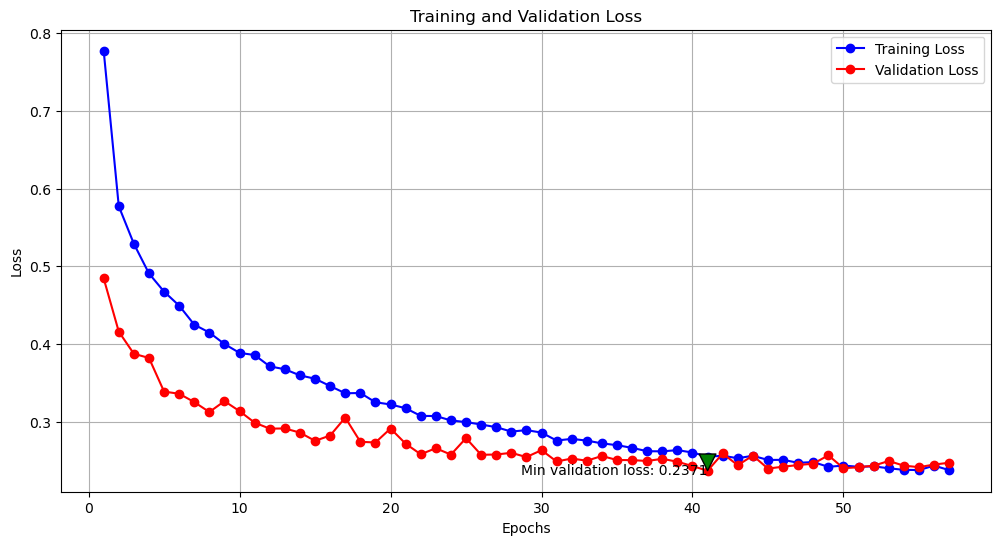

In [185]:
plot_training_history(tr_loss3, val_losses_np)

In [33]:
conv3_model.load_state_dict(torch.load('savesCNN/model3.pt'))
conv3_model.eval()

ConvolutionalNetwork3(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout2d(p=0.25, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=64, bias=True)
  (dropout_fc): Dropout(p=0.35, inplace=False)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [37]:
y, pred = evaluate_model(conv3_model, val_norm_loader, device)

Validate accuracy: 0.914540


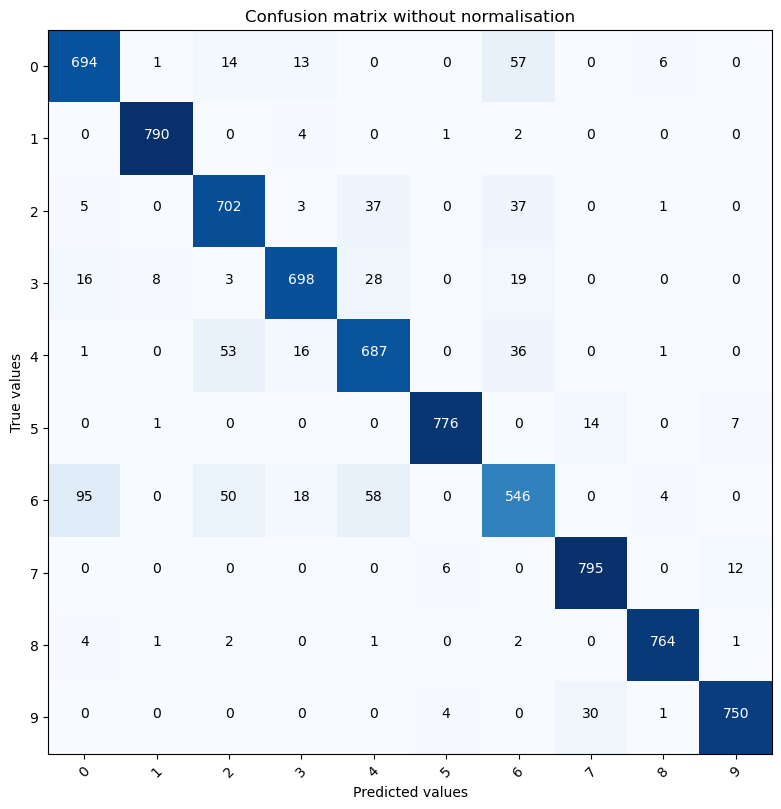

In [208]:
cnf_mtx = confusion_matrix(y, pred)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_mtx, classes=class_names, title='Confusion matrix without normalisation' )
plt.show()

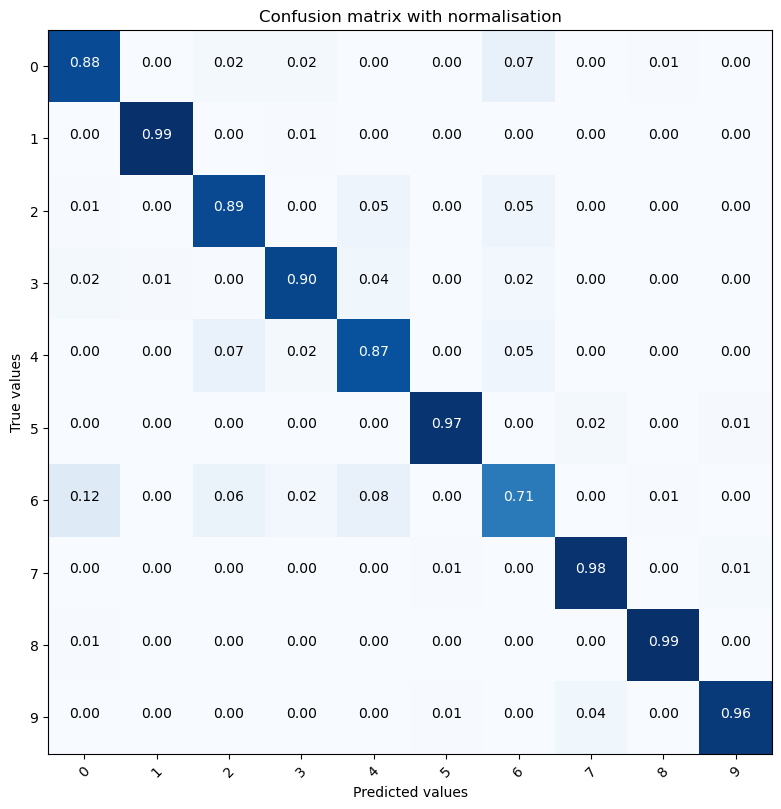

In [209]:
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_mtx, classes=class_names, title='Confusion matrix with normalisation', normalize=True)
plt.show()

- Based on the presented confusion matrix, it can be seen that the overall classification accuracy has improved and most classes have a high proportion of correct predictions, with diagonal values exceeding 0.9. However, the sixth class continues to face accuracy problems with a significant number of classification errors.

# Best model

In [45]:
conv3_model.eval()

ConvolutionalNetwork3(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout2d(p=0.25, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=64, bias=True)
  (dropout_fc): Dropout(p=0.35, inplace=False)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [46]:
test_predictions = np.zeros(len(test_norm_loader.dataset))
test_y = np.zeros(len(test_norm_loader.dataset))
index = 0

for data in tqdm(test_norm_loader, desc="Evaluating model", leave=False):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    with torch.no_grad():
        outputs = conv3_model(inputs)


    test_predictions[index:(index + inputs.shape[0])] = outputs.argmax(1).cpu().numpy()
    test_y[index:(index + inputs.shape[0])] = labels.cpu().numpy()
    index += inputs.shape[0]

print(f"Test accuracy: {accuracy_score(test_y, test_predictions):.4f}")

Test accuracy: 0.9103


- We can assume that the accuracy on the new data will be around 0.91 (I hope so).

## Retrain best model

- I will try to train the model again with the same parameters but use more data in training. I had a split of 70 training set, 15 validation and 15 test set. Now I will split 80 for training and 20 for validation. I will have more data to train but also make sure to prevent overtraining. This approach may slightly improve the accuracy of the model prediction

In [49]:
data = pd.read_csv("train.csv")

In [85]:
X = data.iloc[:, :1024].values  # pixel data
y = data['label'].values   # labels

In [86]:
X_best_train, X_best_val, y_best_train, y_best_val = train_test_split(X, y, test_size=0.2, random_state=367) # 80% training, 20% val

In [87]:
X_best_train =  X_best_train / 255.0  # the best results were on normalised data
X_best_val = X_best_val / 255.0

In [88]:
train_best_dataset = CustomDataset(X_best_train, y_best_train, transform=transform_norm)
val_best_dataset = CustomDataset(X_best_val, y_best_val, transform=basic_transform) # no augmentation for validate data

In [89]:
sampler_best = RandomSampler(train_best_dataset, generator=generator)
train_best_loader = DataLoader(train_best_dataset, batch_size=64, shuffle=False, sampler=sampler_best)
val_best_loader = DataLoader(val_best_dataset, batch_size=64, shuffle=False)

In [90]:
best_model = ConvolutionalNetwork3()
best_model.to(device)

ConvolutionalNetwork3(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout2d(p=0.25, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=64, bias=True)
  (dropout_fc): Dropout(p=0.35, inplace=False)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [91]:
loss_fn = torch.nn.CrossEntropyLoss()

In [92]:
optimizer = torch.optim.Adam(best_model.parameters(), weight_decay=0.0001)

In [93]:
tr_best_loss, val_best_loss = train_n_epochsCNN(best_model, loss_fn, optimizer, train_best_loader, val_best_loader, "savesCNN/best.pt")

EPOCH 1:


100%|██████████| 657/657 [00:11<00:00, 58.26it/s]


TRAIN loss: 0.857, VALIDATION loss: 0.505, accuraccy: 0.814
Saving best model
EPOCH 2:


100%|██████████| 657/657 [00:11<00:00, 56.66it/s]


TRAIN loss: 0.657, VALIDATION loss: 0.461, accuraccy: 0.829
Saving best model
EPOCH 3:


100%|██████████| 657/657 [00:10<00:00, 62.47it/s]


TRAIN loss: 0.608, VALIDATION loss: 0.423, accuraccy: 0.846
Saving best model
EPOCH 4:


100%|██████████| 657/657 [00:10<00:00, 60.06it/s]


TRAIN loss: 0.567, VALIDATION loss: 0.409, accuraccy: 0.847
Saving best model
EPOCH 5:


100%|██████████| 657/657 [00:10<00:00, 60.83it/s]


TRAIN loss: 0.552, VALIDATION loss: 0.380, accuraccy: 0.861
Saving best model
EPOCH 6:


100%|██████████| 657/657 [00:10<00:00, 63.04it/s]


TRAIN loss: 0.528, VALIDATION loss: 0.367, accuraccy: 0.863
Saving best model
EPOCH 7:


100%|██████████| 657/657 [00:10<00:00, 60.31it/s]


TRAIN loss: 0.512, VALIDATION loss: 0.350, accuraccy: 0.875
Saving best model
EPOCH 8:


100%|██████████| 657/657 [00:10<00:00, 62.24it/s]


TRAIN loss: 0.502, VALIDATION loss: 0.339, accuraccy: 0.875
Saving best model
EPOCH 9:


100%|██████████| 657/657 [00:10<00:00, 63.43it/s]


TRAIN loss: 0.475, VALIDATION loss: 0.350, accuraccy: 0.872
No improvement in this epoch.
EPOCH 10:


100%|██████████| 657/657 [00:10<00:00, 61.65it/s]


TRAIN loss: 0.454, VALIDATION loss: 0.330, accuraccy: 0.879
Saving best model
EPOCH 11:


100%|██████████| 657/657 [00:10<00:00, 62.97it/s]


TRAIN loss: 0.449, VALIDATION loss: 0.328, accuraccy: 0.880
Saving best model
EPOCH 12:


100%|██████████| 657/657 [00:09<00:00, 66.97it/s]


TRAIN loss: 0.436, VALIDATION loss: 0.319, accuraccy: 0.884
Saving best model
EPOCH 13:


100%|██████████| 657/657 [00:10<00:00, 65.59it/s]


TRAIN loss: 0.427, VALIDATION loss: 0.328, accuraccy: 0.878
No improvement in this epoch.
EPOCH 14:


100%|██████████| 657/657 [00:10<00:00, 65.52it/s]


TRAIN loss: 0.412, VALIDATION loss: 0.311, accuraccy: 0.886
Saving best model
EPOCH 15:


100%|██████████| 657/657 [00:09<00:00, 66.75it/s]


TRAIN loss: 0.400, VALIDATION loss: 0.298, accuraccy: 0.888
Saving best model
EPOCH 16:


100%|██████████| 657/657 [00:09<00:00, 66.68it/s]


TRAIN loss: 0.386, VALIDATION loss: 0.299, accuraccy: 0.889
No improvement in this epoch.
EPOCH 17:


100%|██████████| 657/657 [00:10<00:00, 65.68it/s]


TRAIN loss: 0.379, VALIDATION loss: 0.305, accuraccy: 0.889
No improvement in this epoch.
EPOCH 18:


100%|██████████| 657/657 [00:10<00:00, 65.05it/s]


TRAIN loss: 0.374, VALIDATION loss: 0.286, accuraccy: 0.897
Saving best model
EPOCH 19:


100%|██████████| 657/657 [00:10<00:00, 64.08it/s]


TRAIN loss: 0.362, VALIDATION loss: 0.301, accuraccy: 0.893
No improvement in this epoch.
EPOCH 20:


100%|██████████| 657/657 [00:10<00:00, 63.60it/s]


TRAIN loss: 0.359, VALIDATION loss: 0.290, accuraccy: 0.894
No improvement in this epoch.
EPOCH 21:


100%|██████████| 657/657 [00:10<00:00, 65.43it/s]


TRAIN loss: 0.354, VALIDATION loss: 0.290, accuraccy: 0.893
No improvement in this epoch.
EPOCH 22:


100%|██████████| 657/657 [00:09<00:00, 66.44it/s]


TRAIN loss: 0.349, VALIDATION loss: 0.278, accuraccy: 0.899
Saving best model
EPOCH 23:


100%|██████████| 657/657 [00:10<00:00, 64.04it/s]


TRAIN loss: 0.342, VALIDATION loss: 0.274, accuraccy: 0.900
Saving best model
EPOCH 24:


100%|██████████| 657/657 [00:10<00:00, 64.92it/s]


TRAIN loss: 0.340, VALIDATION loss: 0.274, accuraccy: 0.900
Saving best model
EPOCH 25:


100%|██████████| 657/657 [00:09<00:00, 67.98it/s]


TRAIN loss: 0.333, VALIDATION loss: 0.270, accuraccy: 0.900
Saving best model
EPOCH 26:


100%|██████████| 657/657 [00:09<00:00, 67.63it/s]


TRAIN loss: 0.334, VALIDATION loss: 0.270, accuraccy: 0.900
Saving best model
EPOCH 27:


100%|██████████| 657/657 [00:09<00:00, 66.43it/s]


TRAIN loss: 0.330, VALIDATION loss: 0.276, accuraccy: 0.898
No improvement in this epoch.
EPOCH 28:


100%|██████████| 657/657 [00:09<00:00, 66.67it/s]


TRAIN loss: 0.330, VALIDATION loss: 0.264, accuraccy: 0.905
Saving best model
EPOCH 29:


100%|██████████| 657/657 [00:09<00:00, 67.33it/s]


TRAIN loss: 0.321, VALIDATION loss: 0.283, accuraccy: 0.897
No improvement in this epoch.
EPOCH 30:


100%|██████████| 657/657 [00:11<00:00, 58.83it/s]


TRAIN loss: 0.323, VALIDATION loss: 0.277, accuraccy: 0.899
No improvement in this epoch.
EPOCH 31:


100%|██████████| 657/657 [00:10<00:00, 65.27it/s]


TRAIN loss: 0.315, VALIDATION loss: 0.278, accuraccy: 0.898
No improvement in this epoch.
EPOCH 32:


100%|██████████| 657/657 [00:09<00:00, 67.13it/s]


TRAIN loss: 0.317, VALIDATION loss: 0.264, accuraccy: 0.906
No improvement in this epoch.
EPOCH 33:


100%|██████████| 657/657 [00:09<00:00, 67.28it/s]


TRAIN loss: 0.314, VALIDATION loss: 0.274, accuraccy: 0.900
No improvement in this epoch.
EPOCH 34:


100%|██████████| 657/657 [00:09<00:00, 66.29it/s]


TRAIN loss: 0.316, VALIDATION loss: 0.257, accuraccy: 0.907
Saving best model
EPOCH 35:


100%|██████████| 657/657 [00:09<00:00, 67.40it/s]


TRAIN loss: 0.310, VALIDATION loss: 0.260, accuraccy: 0.905
No improvement in this epoch.
EPOCH 36:


100%|██████████| 657/657 [00:10<00:00, 63.96it/s]


TRAIN loss: 0.306, VALIDATION loss: 0.258, accuraccy: 0.904
No improvement in this epoch.
EPOCH 37:


100%|██████████| 657/657 [00:11<00:00, 58.58it/s]


TRAIN loss: 0.308, VALIDATION loss: 0.262, accuraccy: 0.903
No improvement in this epoch.
EPOCH 38:


100%|██████████| 657/657 [00:10<00:00, 64.94it/s]


TRAIN loss: 0.304, VALIDATION loss: 0.290, accuraccy: 0.893
No improvement in this epoch.
EPOCH 39:


100%|██████████| 657/657 [00:09<00:00, 67.19it/s]


TRAIN loss: 0.304, VALIDATION loss: 0.279, accuraccy: 0.898
No improvement in this epoch.
EPOCH 40:


100%|██████████| 657/657 [00:09<00:00, 66.27it/s]


TRAIN loss: 0.304, VALIDATION loss: 0.261, accuraccy: 0.906
No improvement in this epoch.
EPOCH 41:


100%|██████████| 657/657 [00:10<00:00, 65.20it/s]


TRAIN loss: 0.301, VALIDATION loss: 0.263, accuraccy: 0.905
No improvement in this epoch.
EPOCH 42:


100%|██████████| 657/657 [00:09<00:00, 66.42it/s]


TRAIN loss: 0.303, VALIDATION loss: 0.258, accuraccy: 0.906
No improvement in this epoch.
EPOCH 43:


100%|██████████| 657/657 [00:09<00:00, 66.75it/s]


TRAIN loss: 0.299, VALIDATION loss: 0.256, accuraccy: 0.907
Saving best model
EPOCH 44:


100%|██████████| 657/657 [00:09<00:00, 66.63it/s]


TRAIN loss: 0.297, VALIDATION loss: 0.263, accuraccy: 0.904
No improvement in this epoch.
EPOCH 45:


100%|██████████| 657/657 [00:09<00:00, 66.28it/s]


TRAIN loss: 0.299, VALIDATION loss: 0.263, accuraccy: 0.905
No improvement in this epoch.
EPOCH 46:


100%|██████████| 657/657 [00:10<00:00, 64.33it/s]


TRAIN loss: 0.293, VALIDATION loss: 0.252, accuraccy: 0.908
Saving best model
EPOCH 47:


100%|██████████| 657/657 [00:09<00:00, 66.10it/s]


TRAIN loss: 0.291, VALIDATION loss: 0.254, accuraccy: 0.909
No improvement in this epoch.
EPOCH 48:


100%|██████████| 657/657 [00:10<00:00, 65.63it/s]


TRAIN loss: 0.293, VALIDATION loss: 0.263, accuraccy: 0.903
No improvement in this epoch.
EPOCH 49:


100%|██████████| 657/657 [00:10<00:00, 63.90it/s]


TRAIN loss: 0.289, VALIDATION loss: 0.259, accuraccy: 0.907
No improvement in this epoch.
EPOCH 50:


100%|██████████| 657/657 [00:10<00:00, 64.99it/s]


TRAIN loss: 0.292, VALIDATION loss: 0.258, accuraccy: 0.908
No improvement in this epoch.
EPOCH 51:


100%|██████████| 657/657 [00:09<00:00, 66.29it/s]


TRAIN loss: 0.289, VALIDATION loss: 0.259, accuraccy: 0.906
No improvement in this epoch.
EPOCH 52:


100%|██████████| 657/657 [00:10<00:00, 63.47it/s]


TRAIN loss: 0.291, VALIDATION loss: 0.250, accuraccy: 0.907
Saving best model
EPOCH 53:


100%|██████████| 657/657 [00:09<00:00, 66.61it/s]


TRAIN loss: 0.287, VALIDATION loss: 0.271, accuraccy: 0.902
No improvement in this epoch.
EPOCH 54:


100%|██████████| 657/657 [00:09<00:00, 66.42it/s]


TRAIN loss: 0.291, VALIDATION loss: 0.253, accuraccy: 0.905
No improvement in this epoch.
EPOCH 55:


100%|██████████| 657/657 [00:09<00:00, 67.29it/s]


TRAIN loss: 0.286, VALIDATION loss: 0.250, accuraccy: 0.910
No improvement in this epoch.
EPOCH 56:


100%|██████████| 657/657 [00:09<00:00, 66.36it/s]


TRAIN loss: 0.290, VALIDATION loss: 0.253, accuraccy: 0.907
No improvement in this epoch.
EPOCH 57:


100%|██████████| 657/657 [00:10<00:00, 63.88it/s]


TRAIN loss: 0.289, VALIDATION loss: 0.253, accuraccy: 0.907
No improvement in this epoch.
EPOCH 58:


100%|██████████| 657/657 [00:11<00:00, 54.95it/s]


TRAIN loss: 0.282, VALIDATION loss: 0.253, accuraccy: 0.908
No improvement in this epoch.
EPOCH 59:


100%|██████████| 657/657 [00:10<00:00, 61.54it/s]


TRAIN loss: 0.285, VALIDATION loss: 0.255, accuraccy: 0.905
No improvement in this epoch.
EPOCH 60:


100%|██████████| 657/657 [00:10<00:00, 64.94it/s]


TRAIN loss: 0.286, VALIDATION loss: 0.257, accuraccy: 0.905
No improvement in this epoch.
EPOCH 61:


100%|██████████| 657/657 [00:09<00:00, 65.85it/s]


TRAIN loss: 0.280, VALIDATION loss: 0.262, accuraccy: 0.905
No improvement in this epoch.
EPOCH 62:


100%|██████████| 657/657 [00:09<00:00, 67.06it/s]


TRAIN loss: 0.284, VALIDATION loss: 0.252, accuraccy: 0.907
No improvement in this epoch.
EPOCH 63:


100%|██████████| 657/657 [00:09<00:00, 67.80it/s]


TRAIN loss: 0.278, VALIDATION loss: 0.264, accuraccy: 0.901
No improvement in this epoch.
EPOCH 64:


100%|██████████| 657/657 [00:09<00:00, 66.19it/s]


TRAIN loss: 0.283, VALIDATION loss: 0.273, accuraccy: 0.900
No improvement in this epoch.
EPOCH 65:


100%|██████████| 657/657 [00:09<00:00, 67.01it/s]


TRAIN loss: 0.281, VALIDATION loss: 0.259, accuraccy: 0.908
No improvement in this epoch.
EPOCH 66:


100%|██████████| 657/657 [00:09<00:00, 67.27it/s]


TRAIN loss: 0.283, VALIDATION loss: 0.258, accuraccy: 0.906
No improvement in this epoch.
EPOCH 67:


100%|██████████| 657/657 [00:09<00:00, 66.62it/s]


TRAIN loss: 0.282, VALIDATION loss: 0.247, accuraccy: 0.912
Saving best model
EPOCH 68:


100%|██████████| 657/657 [00:09<00:00, 67.41it/s]


TRAIN loss: 0.279, VALIDATION loss: 0.258, accuraccy: 0.907
No improvement in this epoch.
EPOCH 69:


100%|██████████| 657/657 [00:10<00:00, 64.50it/s]


TRAIN loss: 0.278, VALIDATION loss: 0.262, accuraccy: 0.906
No improvement in this epoch.
EPOCH 70:


100%|██████████| 657/657 [00:10<00:00, 62.00it/s]


TRAIN loss: 0.283, VALIDATION loss: 0.253, accuraccy: 0.909
No improvement in this epoch.
EPOCH 71:


100%|██████████| 657/657 [00:10<00:00, 61.78it/s]


TRAIN loss: 0.278, VALIDATION loss: 0.256, accuraccy: 0.907
No improvement in this epoch.
EPOCH 72:


100%|██████████| 657/657 [00:10<00:00, 63.47it/s]


TRAIN loss: 0.277, VALIDATION loss: 0.254, accuraccy: 0.908
No improvement in this epoch.
EPOCH 73:


100%|██████████| 657/657 [00:09<00:00, 67.07it/s]


TRAIN loss: 0.276, VALIDATION loss: 0.252, accuraccy: 0.908
No improvement in this epoch.
EPOCH 74:


100%|██████████| 657/657 [00:10<00:00, 60.79it/s]


TRAIN loss: 0.277, VALIDATION loss: 0.270, accuraccy: 0.899
No improvement in this epoch.
EPOCH 75:


100%|██████████| 657/657 [00:10<00:00, 64.69it/s]


TRAIN loss: 0.279, VALIDATION loss: 0.255, accuraccy: 0.908
No improvement in this epoch.
EPOCH 76:


100%|██████████| 657/657 [00:09<00:00, 65.83it/s]


TRAIN loss: 0.280, VALIDATION loss: 0.246, accuraccy: 0.909
Saving best model
EPOCH 77:


100%|██████████| 657/657 [00:09<00:00, 66.86it/s]


TRAIN loss: 0.277, VALIDATION loss: 0.255, accuraccy: 0.907
No improvement in this epoch.
EPOCH 78:


100%|██████████| 657/657 [00:09<00:00, 67.01it/s]


TRAIN loss: 0.273, VALIDATION loss: 0.261, accuraccy: 0.904
No improvement in this epoch.
EPOCH 79:


100%|██████████| 657/657 [00:10<00:00, 64.95it/s]


TRAIN loss: 0.270, VALIDATION loss: 0.257, accuraccy: 0.908
No improvement in this epoch.
EPOCH 80:


100%|██████████| 657/657 [00:10<00:00, 65.00it/s]


TRAIN loss: 0.276, VALIDATION loss: 0.255, accuraccy: 0.907
No improvement in this epoch.
EPOCH 81:


100%|██████████| 657/657 [00:10<00:00, 64.96it/s]


TRAIN loss: 0.277, VALIDATION loss: 0.258, accuraccy: 0.908
No improvement in this epoch.
EPOCH 82:


100%|██████████| 657/657 [00:10<00:00, 62.04it/s]


TRAIN loss: 0.274, VALIDATION loss: 0.255, accuraccy: 0.911
No improvement in this epoch.
EPOCH 83:


100%|██████████| 657/657 [00:10<00:00, 62.29it/s]


TRAIN loss: 0.272, VALIDATION loss: 0.259, accuraccy: 0.908
No improvement in this epoch.
EPOCH 84:


100%|██████████| 657/657 [00:10<00:00, 64.95it/s]


TRAIN loss: 0.272, VALIDATION loss: 0.261, accuraccy: 0.908
No improvement in this epoch.
EPOCH 85:


100%|██████████| 657/657 [00:10<00:00, 64.89it/s]


TRAIN loss: 0.275, VALIDATION loss: 0.252, accuraccy: 0.906
No improvement in this epoch.
EPOCH 86:


100%|██████████| 657/657 [00:10<00:00, 63.53it/s]


TRAIN loss: 0.271, VALIDATION loss: 0.249, accuraccy: 0.908
No improvement in this epoch.
EPOCH 87:


100%|██████████| 657/657 [00:09<00:00, 66.95it/s]


TRAIN loss: 0.273, VALIDATION loss: 0.245, accuraccy: 0.912
Saving best model
EPOCH 88:


100%|██████████| 657/657 [00:09<00:00, 66.31it/s]


TRAIN loss: 0.272, VALIDATION loss: 0.254, accuraccy: 0.907
No improvement in this epoch.
EPOCH 89:


100%|██████████| 657/657 [00:09<00:00, 67.05it/s]


TRAIN loss: 0.271, VALIDATION loss: 0.248, accuraccy: 0.912
No improvement in this epoch.
EPOCH 90:


100%|██████████| 657/657 [00:09<00:00, 66.66it/s]


TRAIN loss: 0.271, VALIDATION loss: 0.273, accuraccy: 0.902
No improvement in this epoch.
EPOCH 91:


100%|██████████| 657/657 [00:10<00:00, 65.55it/s]


TRAIN loss: 0.270, VALIDATION loss: 0.245, accuraccy: 0.909
No improvement in this epoch.
EPOCH 92:


100%|██████████| 657/657 [00:10<00:00, 64.44it/s]


TRAIN loss: 0.271, VALIDATION loss: 0.249, accuraccy: 0.910
No improvement in this epoch.
EPOCH 93:


100%|██████████| 657/657 [00:10<00:00, 64.17it/s]


TRAIN loss: 0.277, VALIDATION loss: 0.261, accuraccy: 0.906
No improvement in this epoch.
EPOCH 94:


100%|██████████| 657/657 [00:10<00:00, 64.81it/s]


TRAIN loss: 0.271, VALIDATION loss: 0.266, accuraccy: 0.903
No improvement in this epoch.
EPOCH 95:


100%|██████████| 657/657 [00:10<00:00, 64.51it/s]


TRAIN loss: 0.267, VALIDATION loss: 0.245, accuraccy: 0.910
No improvement in this epoch.
EPOCH 96:


100%|██████████| 657/657 [00:09<00:00, 66.51it/s]


TRAIN loss: 0.268, VALIDATION loss: 0.249, accuraccy: 0.909
No improvement in this epoch.
EPOCH 97:


100%|██████████| 657/657 [00:09<00:00, 66.87it/s]


TRAIN loss: 0.270, VALIDATION loss: 0.253, accuraccy: 0.907
No improvement in this epoch.
EPOCH 98:


100%|██████████| 657/657 [00:10<00:00, 64.62it/s]


TRAIN loss: 0.267, VALIDATION loss: 0.248, accuraccy: 0.909
No improvement in this epoch.
EPOCH 99:


100%|██████████| 657/657 [00:09<00:00, 66.22it/s]


TRAIN loss: 0.267, VALIDATION loss: 0.256, accuraccy: 0.909
No improvement in this epoch.
EPOCH 100:


100%|██████████| 657/657 [00:09<00:00, 66.24it/s]


TRAIN loss: 0.264, VALIDATION loss: 0.248, accuraccy: 0.909
No improvement in this epoch.


# Results

In [17]:
to_eval = pd.read_csv('evaluate.csv')

In [18]:
Xeval = to_eval.drop(columns=['ID'], errors='ignore')

In [19]:
Xeval = Xeval.values # numpy array
Xeval = Xeval / 255.0

In [20]:
class EvaluationDataset(Dataset):
    """Dataset for evaluating a model on new unlabelled data."""
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        # Returns the total number of samples in the data
        return len(self.dataframe)

    def __getitem__(self, idx):
        x = self.dataframe[idx]

        x = x.reshape(1, 32, 32)

        if self.transform:
            x = self.transform(x)

        return x

In [21]:
eval_dataset = EvaluationDataset(Xeval)
eval_loader = DataLoader(eval_dataset, batch_size=64, shuffle=False)

In [22]:
best_model.load_state_dict(torch.load('savesCNN/best.pt'))
best_model.eval()

NameError: name 'best_model' is not defined

In [150]:
predictions = []
for data in iter(eval_loader):
    inputs = data
    inputs = inputs.to(device)
    inputs = inputs.float()
    with torch.no_grad():
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

In [152]:
# Saving results
results = pd.DataFrame({
    'ID': to_eval['ID'],
    'label': predictions
})
results.to_csv('results.csv', index=False)

In [23]:
res_file = pd.read_csv('results.csv')

In [24]:
res_file['label'].value_counts()

label
2    1898
1    1797
3    1797
7    1776
0    1752
8    1726
9    1717
4    1703
5    1675
6    1659
Name: count, dtype: int64

In [25]:
# Let's have a look
figure = plt.figure(figsize=(20, 20))
cols, rows = 6, 6
for i in range (cols * rows):
    img = Xeval[i].reshape(32, 32)  # row into 32x32 image
    label = predictions[i]
    figure.add_subplot(rows, cols, i+1)
    plt.title(f"Predicted label:{label}")
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

NameError: name 'predictions' is not defined

<Figure size 2000x2000 with 0 Axes>

- The fourth picture is quite interesting because it strongly reminds me of a human silhouette. Also, it seems to me that there are a few categorisation errors, for example the first picture is predicted as 4 ( coat according to kaggle ) but it looks more like a pullover ( label 2 ). But I hope the overall accuracy will be in line with expectations.